# CSCI E-109a Group Project
# Title: Cambridge Energy Use Prediction
**Authors:** Jie Zhao, Michael Assmus, Mohanish Kashiwar


## 1. Problem Statement

Our project’s goal is to better understand energy consumption patterns and identify factors potentially affecting energy efficiency in Cambridge buildings. Insights gained from this project can be used to propose data-driven recommendations for reducing energy use and working towards ESG goals in Cambridge.

Using our model, we can predict energy consumption based on property data and provide actionable recommendations to reduce energy usage by identifying key contributing factors.

We use two data sources for the analysis.
- Cambridge Building Energy Use data obtained from the [Cambridge Open Data Portal](https://data.cambridgema.gov/Energy-and-the-Environment/Cambridge-Building-Energy-Use-Disclosure-Ordinance/72g6-j7aq/about_data). It contains energy and water use data gathered under the BEUDO program for years 2015-2022. The data is at the parcel level. Properties subject to BEUDO reporting include large residential (50+ units), nonresidential (25,000+ sq. ft.), and municipal (10,000+ sq. ft.) buildings. 
- Cambridge Property Database data also obtained from the Cambridge Open Data Portal, [here](https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY2016-FY2024/eey2-rv59/about_data). It contains physical details of the properties, including wall types, interior living space, number of kitchens, and much more. The data covers fiscal years 2016 through 2024. The data is at the building or unit level, necessitating aggregation for our purposes. 

We chose to use weather-normalized site energy use intensity (Weather normalized Site EUI (kBtu/ft2)) as our response variable. This variable normalizes for building size and yearly weather variance, allowing us to better focus on the impact of materials, age, and other physical property details.

## 2. Setup

In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import shap
from sklearn.inspection import permutation_importance

## 3. Load and Preview Data 

In [ ]:
# Load data
beudo_url = 'Cambridge_Building_Energy_Use_Disclosure_Ordinance__BEUDO__Data_2015-2022_20241025.csv'
property_db_url = 'Cambridge_Property_Database_FY2016-FY2024_20241112.csv'

energy_data = pd.read_csv(beudo_url)
property_data = pd.read_csv(property_db_url)

# Display basic information about the datasets
print(energy_data.info())
print(property_data.info())

print("\nEnergy data basic stats:")
print(energy_data.describe())

print("\nProperty data basic stats:\n")
print(property_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 46 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Reporting ID                                                     6823 non-null   object 
 1   Data Year                                                        6823 non-null   int64  
 2   MapLot                                                           6823 non-null   object 
 3   Annual Report Received                                           6823 non-null   object 
 4   BEUDO Category                                                   6823 non-null   object 
 5   PD Parcel Living Area                                            6820 non-null   float64
 6   PD Parcel Units                                                  5424 non-null   float64
 7   Address                                   

On first look, we can see that the energy use dataset has 48 columns and about 6800 observations. There are many missing values; three columns have no non-null values at all. Fortunately, the initial ID columns are fully intact.

The property dataset has 62 columns and almost 237,000 observations. There are again many missing values. Some of the columns with many missing values are irrelevant to our model, such as the co-owner's address, but there are others like Systems_Plumbing that should be widely relevant but have very few non-null values.

We already know that the two datasets are at different scales, hence the huge difference in observation counts. Aggregation or disaggregation will be vital here.

We won't comment on specific column summary statistics here, but we can see that many of the columns are heavily right-skewed.

In [ ]:
# Preview energy data
print('Preview energy data')
energy_data.head()

Preview energy data


Reporting ID  Data Year   MapLot Annual Report Received   BEUDO Category  \
0        B1074       2015    95-73                    Yes  Non-Residential   
1        B1420       2015    7-115                     No  Non-Residential   
2        B1465       2015  265B-34                     No  Non-Residential   
3        B1550       2015   162-54                     No  Non-Residential   
4        B1582       2015    14-47                    Yes  Non-Residential   

   PD Parcel Living Area  PD Parcel Units                        Address  \
0                44720.0              1.0           130 Brookline Street   
1                57035.0            123.0  215 Monsignor O'Brien Highway   
2                28054.0              NaN      205 Alewife Brook Parkway   
3                36600.0              7.0              80-90 Winthrop st   
4               356882.0              1.0             500 Kendall Street   

   Year Built Buildings Included  ...  \
0      2010.0              694-4  ...   
1      2015.0              358-1  ...   
2      1975.0              76-21  ...   
3      1975.0             396-10  ...   
4      2002.0              620-2  ...   

   Weather Normalized Source Energy Use (kBtu) Source EUI (kBtu/ft2)  \
0                                          NaN                 801.1   
1                                          NaN                   NaN   
2                                          NaN                   NaN   
3                                          NaN                   NaN   
4                                   58450497.8                 170.0   

  Weather Normalized Source EUI (kBtu/ft2)  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                    167.3   

   Total GHG Emissions (Metric Tons CO2e)  \
0                                  1432.9   
1                                     NaN   
2                                     0.0   
3                                     0.0   
4                                  2174.5   

   Total GHG Emissions Intensity (kgCO2e/ft2)  \
0                                        26.4   
1                                         NaN   
2                                         0.0   
3                                         0.0   
4                                         6.2   

  Water Use (All Water Sources) (kgal)  \
0                               4754.0   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                               7472.3   

  Water Intensity (All Water Sources) (gal/ft2)   Latitude  Longitude  \
0                                         87.64  42.360313 -71.104509   
1                                           NaN  42.372868 -71.079624   
2                                           NaN  42.390311 -71.143107   
3                                           NaN  42.372122 -71.120916   
4                                         21.39  42.363899 -71.081408   

                                     Location  
0  POINT (-71.1045085999411 42.3603129493224)  
1  POINT (-71.0796235216534 42.3728684150094)  
2  POINT (-71.1431074295734 42.3903111902982)  
3   POINT (-71.120916012646 42.3721215961329)  
4  POINT (-71.0814075007659 42.3638994069543)  

[5 rows x 46 columns]

In [ ]:
# Preview property database data
print('Preview property data')
property_data.head()

Preview property data


PID   GISID  BldgNum          Address Unit  Latitude  Longitude  \
0  7344  112-47        1  36 Highland Ave    9   42.3727   -71.1059   
1  7345  112-47        1  36 Highland Ave    A   42.3727   -71.1059   
2  7346  112-47        1  36 Highland Ave    B   42.3727   -71.1059   
3  7347  112-47        1  36 Highland Ave    C   42.3727   -71.1059   
4  7348  112-47        1  36 Highland Ave    D   42.3727   -71.1059   

   StateClassCode PropertyClass Zoning  ... Systems_Plumbing  \
0             102   CONDOMINIUM    NaN  ...              NaN   
1             102   CONDOMINIUM    NaN  ...              NaN   
2             102   CONDOMINIUM    NaN  ...              NaN   
3             102   CONDOMINIUM    NaN  ...              NaN   
4             102   CONDOMINIUM    NaN  ...              NaN   

   Condition_YearBuilt  Condition_InteriorCondition  \
0                 1940                          NaN   
1                 1940                          NaN   
2                 1940                          NaN   
3                 1940                          NaN   
4                 1940                          NaN   

  Condition_OverallCondition  Condition_OverallGrade  Parking_Open  \
0                    Average                 Average           0.0   
1                    Average                 Average           0.0   
2                    Average                 Average           0.0   
3                    Average                 Average           0.0   
4                    Average                 Average           0.0   

   Parking_Covered  Parking_Garage  UnfinishedBasementGross  \
0              0.0             0.0                        0   
1              0.0             0.0                        0   
2              0.0             0.0                        0   
3              0.0             0.0                        0   
4              0.0             0.0                        0   

  FinishedBasementGross  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 62 columns]

A look at the first few rows of each dataset gives us some useful insights. There are some columns that will clearly be useless to our model, such as Address. Some columns are shared between the two datasets and could have potential while merging, like Latitude and Longitude. We can see a number of missing values in both datasets in just these first rows. The Reporting ID and PID of the two datests, their primary ID columns, don't seem to match up in either format or value, so we'll need to merge on something else. MapLot and GISID seem to have the same format, so they or similar columns may have promise.

## 4. Initial exploratory Data Analysis (EDA) and data cleaning


In [ ]:
# As an example, inspect the rows for one particular address
energy_data[energy_data.Address == "130 Brookline Street"]

Reporting ID  Data Year MapLot Annual Report Received   BEUDO Category  \
0           B1074       2015  95-73                    Yes  Non-Residential   
1186        B1074       2019  95-73                    Yes  Non-Residential   
1887        B1074       2018  95-73                    Yes  Non-Residential   
3757        B1074       2016  95-73                    Yes  Non-Residential   
4223        B1074       2021  95-73                    Yes  Non-Residential   
4224        B1074       2022  95-73                    Yes  Non-Residential   
4752        B1074       2017  95-73                    Yes  Non-Residential   
5807        B1074       2020  95-73                    Yes  Non-Residential   

      PD Parcel Living Area  PD Parcel Units               Address  \
0                   44720.0              1.0  130 Brookline Street   
1186                44720.0              1.0  130 Brookline Street   
1887                44720.0              1.0  130 Brookline Street   
3757                44720.0              1.0  130 Brookline Street   
4223                44720.0              1.0  130 Brookline Street   
4224                44720.0              1.0  130 Brookline Street   
4752                44720.0              1.0  130 Brookline Street   
5807                44720.0              1.0  130 Brookline Street   

      Year Built Buildings Included  ...  \
0         2010.0              694-4  ...   
1186      2010.0              694-4  ...   
1887      2010.0              694-4  ...   
3757      2010.0              694-4  ...   
4223      2010.0              694-4  ...   
4224      2010.0              694-4  ...   
4752      2010.0              694-4  ...   
5807      2010.0              694-4  ...   

      Weather Normalized Source Energy Use (kBtu) Source EUI (kBtu/ft2)  \
0                                             NaN                 801.1   
1186                                   47614895.9                 877.4   
1887                                   44994851.0                 831.1   
3757                                          NaN                 794.7   
4223                                   46337321.4                 859.4   
4224                                   46557552.1                 861.8   
4752                                          NaN                 767.2   
5807                                   47797902.6                 862.7   

     Weather Normalized Source EUI (kBtu/ft2)  \
0                                         NaN   
1186                                    877.8   
1887                                    829.5   
3757                                      NaN   
4223                                    854.3   
4224                                    858.3   
4752                                      NaN   
5807                                    881.2   

      Total GHG Emissions (Metric Tons CO2e)  \
0                                     1432.9   
1186                                  1408.5   
1887                                  1389.2   
3757                                  1388.9   
4223                                  1442.8   
4224                                  1440.1   
4752                                  1351.0   
5807                                  1432.8   

      Total GHG Emissions Intensity (kgCO2e/ft2)  \
0                                           26.4   
1186                                        26.0   
1887                                        25.6   
3757                                        25.6   
4223                                        26.6   
4224                                        26.5   
4752                                        24.9   
5807                                        26.4   

     Water Use (All Water Sources) (kgal)  \
0                                  4754.0   
1186                               2737.9   
1887                               2429.9   
3757                               2620.0   
4223                

Further column inspection reveals that we need to merge the two datasets on Data Year and MapLot, which equate to YearOfAssessment and GISID, respectively, in the property dataset. There will be multiple rows in the property dataset for every row in the energy use dataset (for those rows where matches can be found).

We plan to use weather-normalized site energy use intensity as our response variable, but since we may be able to impute that from Site EUI, we will drop rows where Site EUI is null rather than rows where weather-normalized site EUI is null. (Site EUI is non-null for all rows where Weather-normalized Site EUI is non-null.)

We also convert the year columns to datetime to ensure there are no formatting issues later.

In [ ]:
# Remove rows with missing values in response variable
energy_data_clean = energy_data.dropna(subset=['Site EUI (kBtu/ft2)']) #dropna(subset=['Data Year', 'BEUDO Category', 'Source EUI (kBtu/ft2)', 'Total GHG Emissions (Metric Tons CO2e)'])

# Convert 'Data Year' to datetime
energy_data_clean = energy_data_clean.copy() # To handle an irrelevant warning
energy_data_clean['Data Year'] = pd.to_datetime(energy_data_clean['Data Year'], format='%Y')
energy_data_clean = energy_data_clean.copy() # To handle an irrelevant warning
energy_data_clean['Year Built'] = pd.to_datetime(energy_data_clean['Year Built'], format='%Y')
property_data['YearOfAssessment'] = pd.to_datetime(property_data['YearOfAssessment'], format='%Y')

# Merge datasets on Maplot and Year combination. 
merged_data = pd.merge(energy_data_clean, property_data, left_on=['MapLot', 'Data Year'], right_on=['GISID', 'YearOfAssessment'], how='inner')

# Display basic information about the cleaned dataset
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69059 entries, 0 to 69058
Columns: 108 entries, Reporting ID to FinishedBasementGross
dtypes: bool(1), datetime64[ns](3), float64(52), int64(8), object(44)
memory usage: 56.4+ MB
None


The merged dataset contains 108 columns and 69,059 observations. The property use dataset must have many rows that don't match up with the properties included in the energy use dataset. This isn't overly surprising: The energy use dataset has selective rules for what types of properties are required to submit BEUDO reporting.

Now that we have our merged dataset, we can take a closer look at what information is available (and possibly duplicated) for each observation.

In [ ]:
# For better ability to inspect columns, we remove the pandas column display maximum
pd.set_option('display.max_columns', None)

# Inspect the full set of columns for a subset of the dataset
merged_data.iloc[20:30,]

Reporting ID  Data Year  MapLot Annual Report Received   BEUDO Category  \
20        B1360 2017-01-01  157-69                    Yes  Non-Residential   
21        B1360 2017-01-01  157-69                    Yes  Non-Residential   
22        B1360 2017-01-01  157-69                    Yes  Non-Residential   
23        B1360 2017-01-01  157-69                    Yes  Non-Residential   
24        B1360 2017-01-01  157-69                    Yes  Non-Residential   
25        B1898 2017-01-01   18-75                    Yes        Municipal   
26        B1326 2019-01-01  52A-21                    Yes  Non-Residential   
27        B1326 2019-01-01  52A-21                    Yes  Non-Residential   
28        B1326 2019-01-01  52A-21                    Yes  Non-Residential   
29        B1326 2019-01-01  52A-21                    Yes  Non-Residential   

    PD Parcel Living Area  PD Parcel Units               Address_x Year Built  \
20              1462119.0             18.0       10 Everett Street 2010-01-01   
21              1462119.0             18.0       10 Everett Street 2010-01-01   
22              1462119.0             18.0       10 Everett Street 2010-01-01   
23              1462119.0             18.0       10 Everett Street 2010-01-01   
24              1462119.0             18.0       10 Everett Street 2010-01-01   
25                12571.0              0.0    59 & 69 First Street 1993-01-01   
26              3691096.0              0.0  125  MASSACHUSETTS AVE 1928-01-01   
27              3691096.0              0.0  125  MASSACHUSETTS AVE 1928-01-01   
28              3691096.0              0.0  125  MASSACHUSETTS AVE 1928-01-01   
29              3691096.0              0.0  125  MASSACHUSETTS AVE 1928-01-01   

   Buildings Included  Buildings Included Count  \
20              253-6                         1   
21              253-6                         1   
22              253-6                         1   
23              253-6                         1   
24              253-6                         1   
25              505-2                         1   
26             668-33                         1   
27             668-33                         1   
28             668-33                         1   
29             668-33                         1   

   Primary Property Type - Self Selected                    All Property Uses  \
20                               Parking                   Parking (223000.0)   
21                               Parking                   Parking (223000.0)   
22                               Parking                   Parking (223000.0)   
23                               Parking                   Parking (223000.0)   
24                               Parking                   Parking (223000.0)   
25                            Restaurant  Restaurant (3215.0),Parking (697.0)   
26                    College/University         College/University (55046.0)   
27                    College/University         College/University (55046.0)   
28                    College/University         College/University (55046.0)   
29                    College/University         College/University (55046.0)   

    Property GFA - Self Reported (ft2)  Reported Residential Units  \
20                            223000.0                         NaN   
21                            223000.0                         NaN   
22                            223000.0                         NaN   
23                            223000.0                         NaN   
24                            223000.0                         NaN   
25                              3912.0                         NaN   
26                             55046.0                         NaN   
27                             55046.0                         NaN   
28                             55046.0                         NaN   
29                             55046.0                         NaN   

                           

Looking at the first few rows, we see that several buildings are part of the same MapLot and reporting ID. The energy use dataset aggregates them, the property dataset does not. This means the energy use data is duplicated across these rows. The property dataset has useful columns such as exterior wall type, number of stories, etc., things that would be helpful in predicting and evaluating energy usage.

The question: How to relate the energy usage to these buildings? We can't treat each building as using the full amount of energy from the whole map lot. Can we aggregate somehow? Take the mode or mean of the descriptive columns (mode if categorical, mean if ordinal)? Or perhaps we divide energy use proportionally by Interior_LivingArea?

Looking more closely, the energy data in those first rows seems to only include two of the three buildings. Judging by the total living area vs the individual living areas of the buildings, it looks like the gym isn't included. Too small to be counted? Unknown.

Let's explore the data more closely. We'll start by taking a look at the distributions of some of our columns across the BEUDO categories.

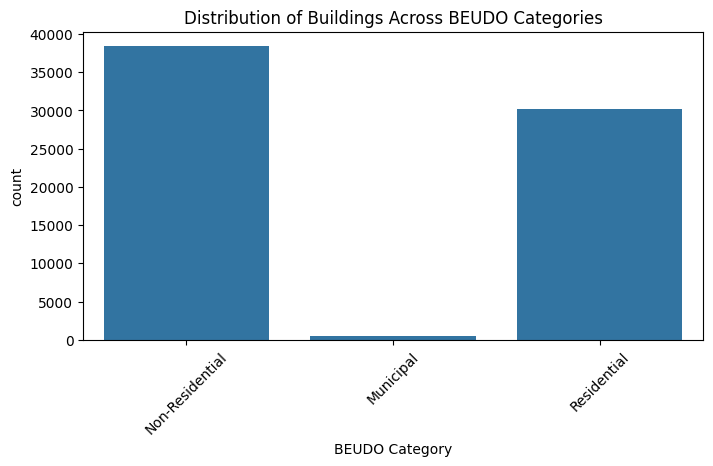

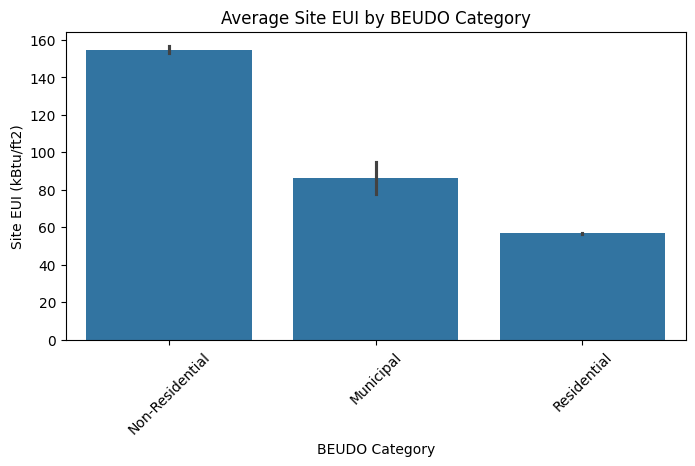

In [ ]:
# Distribution of buildings across BEUDO categories
plt.figure(figsize=(8, 4))
sns.countplot(data=merged_data, x='BEUDO Category')
plt.title('Distribution of Buildings Across BEUDO Categories')
plt.xticks(rotation=45)
plt.show()

# Average Source EUI by BEUDO Category
plt.figure(figsize=(8, 4))
sns.barplot(data=merged_data, x='BEUDO Category', y='Site EUI (kBtu/ft2)')
plt.title('Average Site EUI by BEUDO Category')
plt.xticks(rotation=45)
plt.show()

1. Distribution of Buildings Across BEUDO Categories

- Observation: The vast majority of buildings are categorized as Residential and Non-Residential. The Municipal category has almost no buildings.
- Implication: Municipal buildings have very little data to back them. We can still try to model them, but it's a low priority. For better consistency in column availability, we can start by focusing on the Residential observations. Non-Residential observations are likely to use fewer of the predictive columns than Residential (they're less likely to have bedroom values, for instance), so getting good results is likely to be simultaneously more difficult and less complex.

2. Average Site EUI (Energy Use Intensity) by BEUDO Category

- Observation: Non-Residential buildings have the highest average Site EUI, followed by Municipal buildings, with Residential buildings having the lowest.
- Implication: Non-Residential buildings consume more energy per square foot compared to other categories. This suggests that focusing on those buildings for energy efficiency improvements could yield significant reductions in overall energy consumption. Municipal buildings also present an opportunity for improvement.

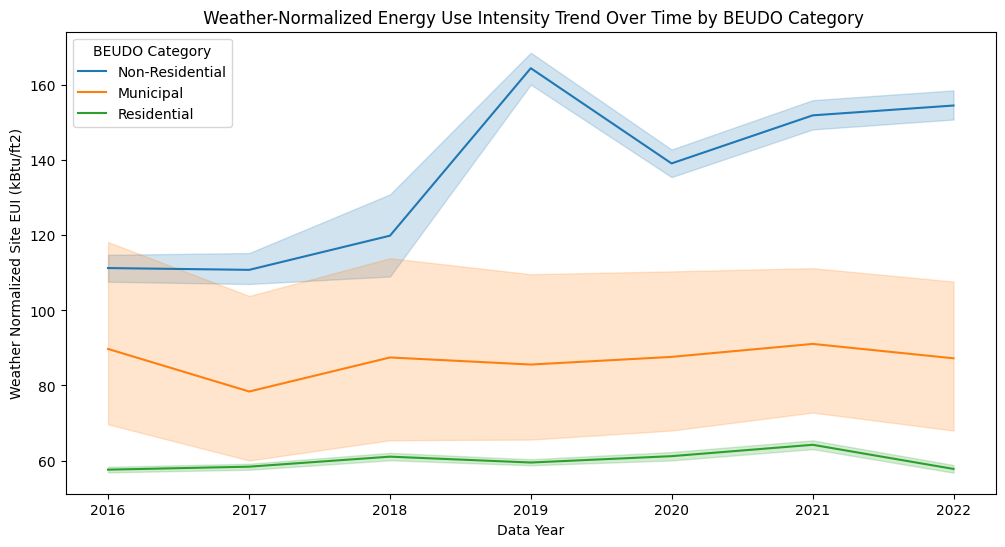

In [ ]:
# Weather-normalized energy use trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_data, x='Data Year', y='Weather Normalized Site EUI (kBtu/ft2)', hue='BEUDO Category')
plt.title(' Weather-Normalized Energy Use Intensity Trend Over Time by BEUDO Category')
plt.show()

4. Weather-Normalized Energy Use Intensity Trend Over Time by BEUDO Category

As a continuation of the above, this is interesting. The Residential and Municipal trends are similar, with peaks in 2018 and 2021. The Non-Residential trend, meanwhile, changes dramatically. It now peaks in 2019 after a much lower preceding three years. It drops again in 2020, then starts trending upward.

The pattern from 2019 onward does stay mostly consistent between normalized and unnormalized EUI. Perhaps the drop in Non-Residential in 2020 is linked to the COVID pandemic, and as conditions improved business recovered?

One way or another, we can see that year will be a major predictor for Non-Residential data. Whether the trend assigned to it is real or not is unclear. The energy use certainly varies dramatically, but the buildings presumably aren't changing nearly so frequently.

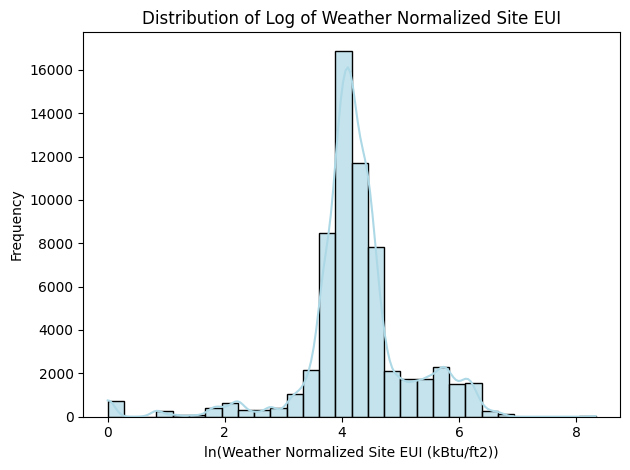

In [ ]:
# Inspect distribution of log of weather normalized site EUI
Log_EUI = np.log1p(merged_data['Weather Normalized Site EUI (kBtu/ft2)'])
sns.histplot(data=merged_data, x=Log_EUI, bins=30, kde=True, color='lightblue', alpha=0.7)

# Add labels and title
plt.title("Distribution of Log of Weather Normalized Site EUI")
plt.xlabel("ln(Weather Normalized Site EUI (kBtu/ft2))")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

5. Log of Weather-Normalized Site EUI Distribution
   
- Observation: The log-transformed weather-normalized Site EUI closely follows a normal distribution. The majority of values cluster around 40,000, with a noticeable left skew at the lower end. The log-transformed weather-normalized site EUI should serve us well as a response variable no matter what model we use.

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
Why does this matter? This goes back to the advice to only include things that you have something to say about or interpret
</div>

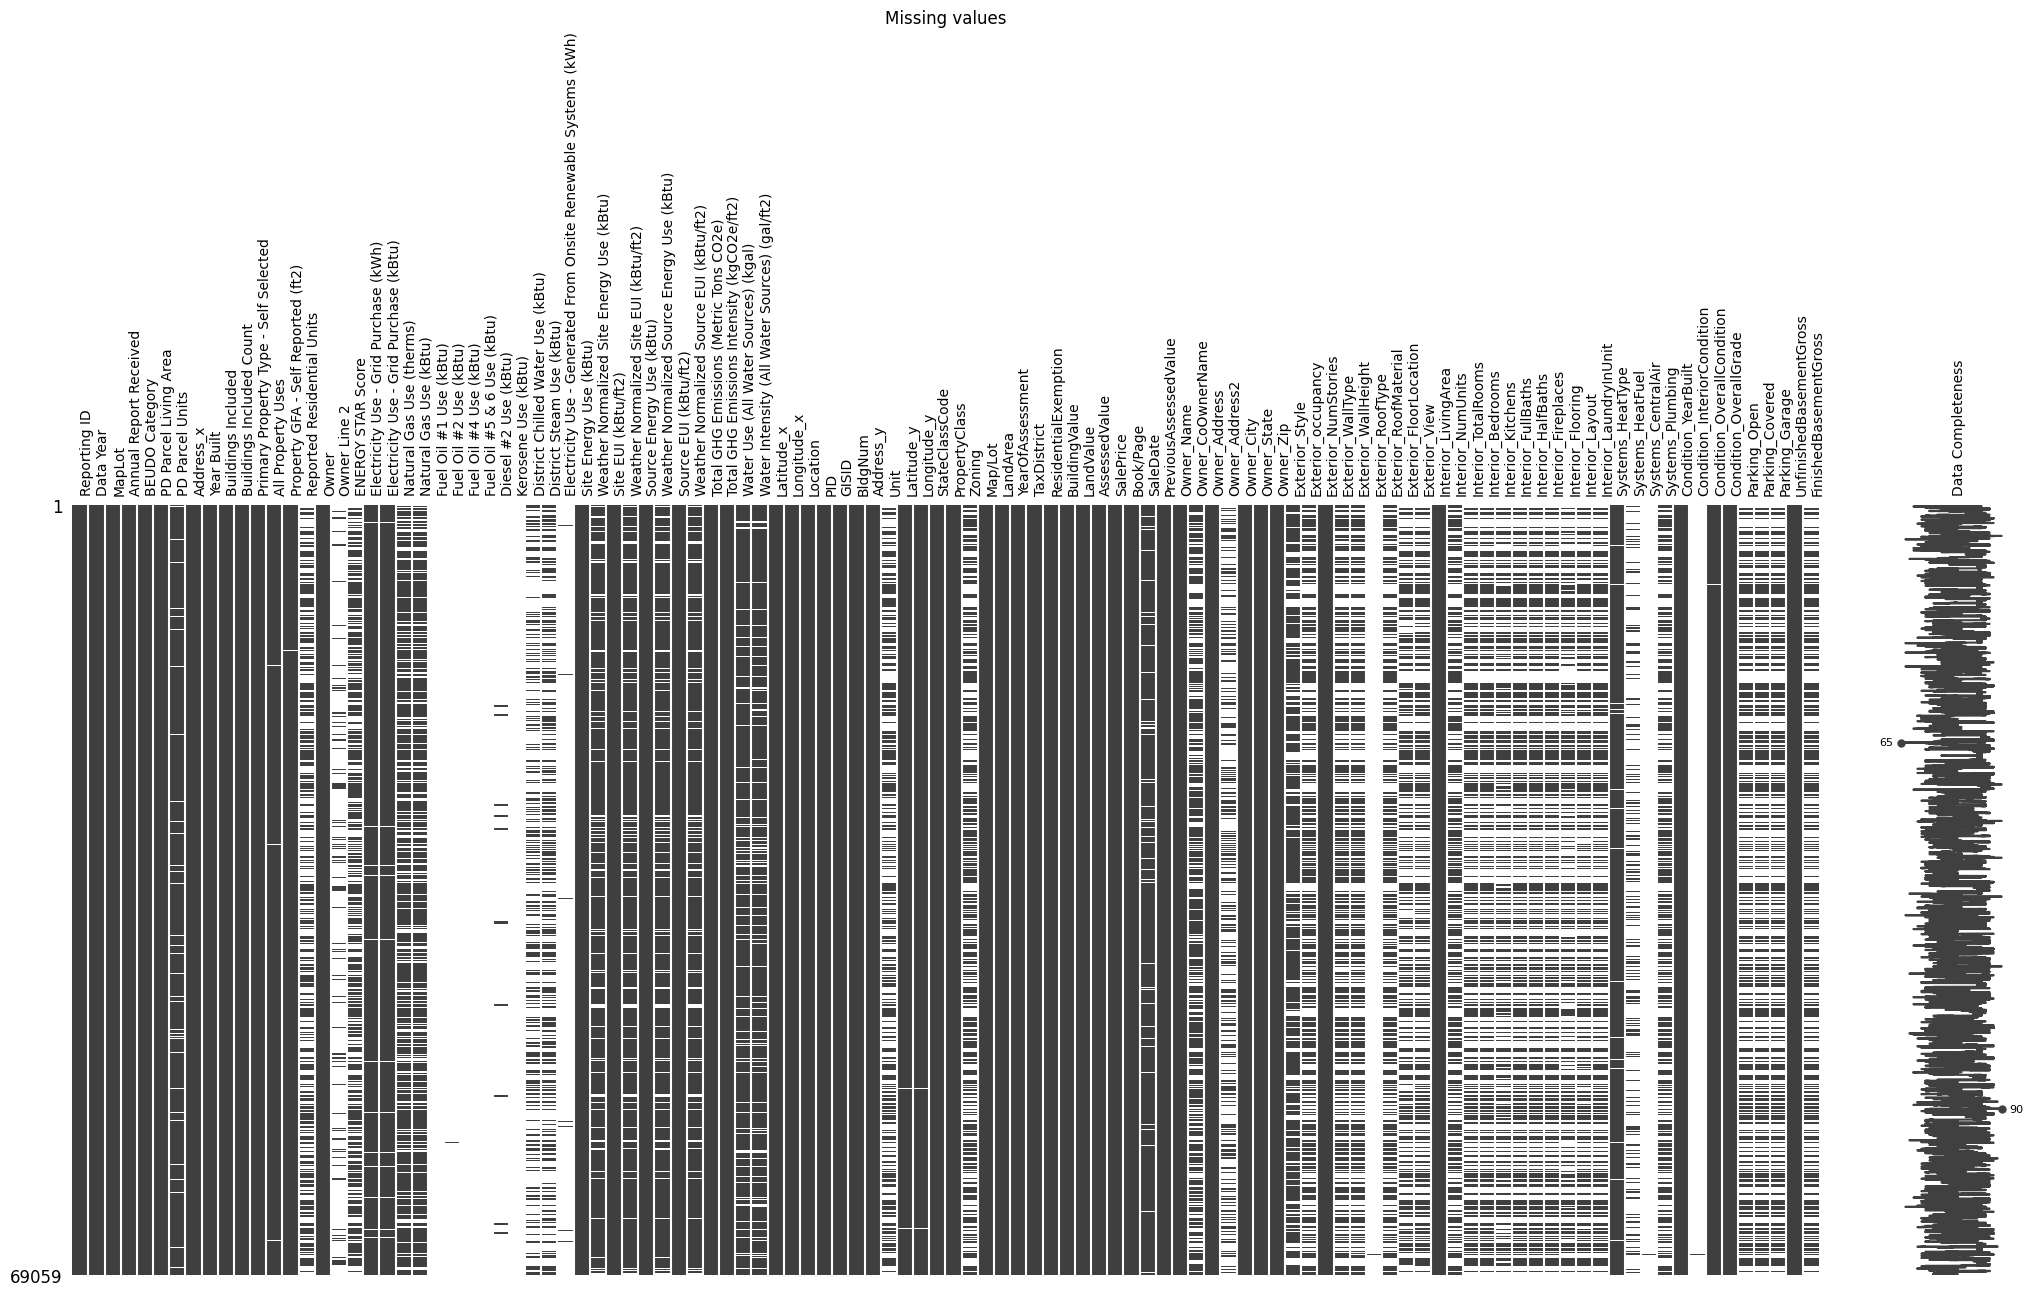

In [ ]:
# Plot missing values
msno.matrix(merged_data, labels=True, label_rotation=90, fontsize=10)
plt.title('Missing values')
plt.show()

6. Missing values

We can see some trends in missing values. The large white block toward the left is the individual fuel use columns, several of which have no entries at all. Those technically aren't missing, the null values just indicate that none of that fuel was used. The columns after that are the overall energy use columns, and we can see that rows that lack a value in one weather-normalized column appear to lack values in all weather-normalized columns.

There are columns in other areas that are concerningly sparse. Exterior_RoofType appears to be almost completely missing, as are Systems_CentralAir and Condition_Interior.

Comparing across the rows, it looks like rows with Unit values (presumably representing individual residential units) are the only ones with values for most of the Interior_ columns, while those without Unit values are the only ones with Exterior_ values. The Unit rows are also the ones with Parking_ and FinishedBasementGross values.

We will need to figure out how to handle these groupings separately.

In [ ]:
# Plot distributions of all the variables
#fig, axes = plt.subplots(ncols=5, nrows=22, figsize=(30,110))
#axes = axes.flatten()
#for i,var in enumerate(merged_data.columns):
#    if merged_data[var].dtype == 'float64':
#        sns.histplot(merged_data, x=var, ax=axes[i])
#    else:
#        sns.countplot(merged_data, x=var, ax=axes[i])

#### a. Data Inspection and Cleaning

In [ ]:
# Drop extraneous and irrelevant columns
bad_metadata = ['MapLot', 'Address_x', 'Address_y', 'Buildings Included', 'All Property Uses', 'Owner', 'Owner Line 2', 
                'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (therms)', 'Latitude_x', 'Latitude_y', 'Longitude_x', 'Longitude_y',
                'Location', 'PID', 'GISID', 'StateClassCode', 'PropertyClass', 'Zoning', 'Map/Lot', 'YearOfAssessment', 'TaxDistrict', 'ResidentialExemption',
                'BuildingValue', 'LandValue', 'AssessedValue', 'SalePrice', 'Book/Page', 'SaleDate', 'PreviousAssessedValue', 'Owner_Name',
                'Owner_CoOwnerName', 'Owner_Address', 'Owner_Address2', 'Owner_City', 'Owner_State', 'Owner_Zip']
merged_data = merged_data.drop(bad_metadata, axis=1)

We'll leave some questionable metadata columns in for now. Specifically, Annual Report Received.

Buildings Included is probably counterproductive for prediction, but it's useful for other comparisons. We'll drop it later.

All Property Uses could theoretically be turned into a mix of categorical values. Perhaps make a set of columns indicating amount of square feet dedicated to each of a number of common uses? We'll drop it for now, but we might be able to make use of it later.

It occurs to us that pretty much every energy use column in the energy dataset isn't usable for this. They just sum up to site energy use. They're the result, not the cause. Though we could potentially use them to create "uses X energy source" columns...

We'll set those ideas aside for the moment. For now, we have typos to fix and cleaning to do.

In [ ]:
# Fix typos in categorical columns
merged_data.loc[merged_data.Systems_HeatType == 'Hot Water', 'Systems_HeatType'] = 'HOT-WATER'
merged_data.loc[merged_data.Systems_HeatType == 'Heat Pump', 'Systems_HeatType'] = 'HEAT-PUMP'
merged_data.loc[merged_data.Systems_HeatType == 'H.V.A.C', 'Systems_HeatType'] = 'H.V.A.C.'
merged_data.loc[merged_data.Systems_HeatType == 'Other', 'Systems_HeatType'] = 'OTHER'
merged_data.loc[merged_data.Systems_HeatType == 'Space Heat', 'Systems_HeatType'] = 'SPACE-HEAT'
merged_data.loc[merged_data.Systems_HeatType == 'Steam', 'Systems_HeatType'] = 'STEAM'
merged_data.loc[merged_data.Systems_HeatType == 'HW Radiator', 'Systems_HeatType'] = 'HOT-WATR-RAD'
merged_data.loc[merged_data.Systems_HeatType == 'Forced Air', 'Systems_HeatType'] = 'FORCED-AIR'
merged_data.loc[merged_data.Systems_HeatType == 'Elec Wall', 'Systems_HeatType'] = 'ELEC-WALL'
merged_data.loc[merged_data.Systems_HeatType == 'Elec-Radiant', 'Systems_HeatType'] = 'ELEC-RADIANT'

merged_data.loc[merged_data['Condition_OverallGrade'] == 'Good', 'Condition_OverallGrade'] = 'GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Good Very Good', 'Condition_OverallGrade'] = 'GOOD VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Average', 'Condition_OverallGrade'] = 'AVERAGE'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Excellent', 'Condition_OverallGrade'] = 'EXCELLENT'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Fair', 'Condition_OverallGrade'] = 'FAIR'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'GOOD-V-GOOD', 'Condition_OverallGrade'] = 'GOOD VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'VERY-GOOD', 'Condition_OverallGrade'] = 'VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'VERY-GOOD-EX', 'Condition_OverallGrade'] = 'VERY GOOD EXCELLENT'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'VERY-GOOD', 'Condition_OverallGrade'] = 'VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Good Very Good', 'Condition_OverallGrade'] = 'GOOD VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Very Good', 'Condition_OverallGrade'] = 'VERY GOOD'
merged_data.loc[merged_data['Condition_OverallGrade'] == 'Poor', 'Condition_OverallGrade'] = 'POOR'

In [ ]:
# Check the options for interior kitchens
merged_data.Interior_Kitchens.value_counts()

Interior_Kitchens
Pull Alcove    15795
Galley          8171
Full Eat In     5158
2                 94
6                 84
0                 23
1                  2
3                  1
Name: count, dtype: int64

We can't weight the kitchens by interior living space. One kitchen is still one kitchen, no matter how much space the living area takes up. With the variety of options available, we also can't make use of the three descriptive responses. We doubt the type is important to energy consumption anyway. Instead, we'll convert to counts. Pull Alcove, Galley, and Full Eat In will all be translated to 1 and then the column will be treated as numeric. We'll sum it when aggregating to property.

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
Some of the observations like this one about the kitchens seem to come from nowhere and aren't obviously connected to what came before. It's important to explain the larger motivation when introducing new ideas and to try to tell a clear story throughout. Most of the work that you do in this section is not work that you need to talk about in much detail. Maybe just give a summary of what you did and why at the top of the section.
</div>

In [ ]:
# Check the options for interior flooring and layout
print(merged_data.Interior_Flooring.value_counts(dropna=False))
merged_data.Interior_Layout.value_counts(dropna=False)

Interior_Flooring
NaN               39981
Hardwood          25345
Carpet             3299
Vinyl/Linoleum      240
Softwood            123
Cermc/Qry Tile       57
Marble               14
Name: count, dtype: int64


Interior_Layout
NaN            38187
No Impact      19543
Corner Unit     7419
Thru Unit       3572
Poor             305
Superior          33
Name: count, dtype: int64

These descriptive columns are good, at least. There are plenty of missing values, but the categories themselves are coherent. Not ordered, though; we'll need to one-hot encode them, and in this case we'll need to keep all of the categories. The default will be "None of the above", i.e. either N/A or missing. (We'll want to do something about ones that are missing that shouldn't be.)

In [ ]:
# Check whether there are any rows without annual report received
merged_data['Annual Report Received'].value_counts(dropna=False)

Annual Report Received
Yes    69056
No         3
Name: count, dtype: int64

In [ ]:
# Look at the few rows where annual report isn't received
merged_data[merged_data['Annual Report Received'] == 'No']

Reporting ID  Data Year Annual Report Received   BEUDO Category  \
47499        B1139 2018-01-01                     No  Non-Residential   
52417        B1241 2021-01-01                     No      Residential   
52530        B1241 2020-01-01                     No      Residential   

       PD Parcel Living Area  PD Parcel Units Year Built  \
47499               182389.0              NaN 2017-01-01   
52417                62875.0              NaN 1893-01-01   
52530                62875.0              NaN 1893-01-01   

       Buildings Included Count Primary Property Type - Self Selected  \
47499                         1                    College/University   
52417                         1              Residence Hall/Dormitory   
52530                         1              Residence Hall/Dormitory   

       Property GFA - Self Reported (ft2)  Reported Residential Units  \
47499                            102899.0                         NaN   
52417                             58818.0                         NaN   
52530                             58818.0                         NaN   

       ENERGY STAR Score  Electricity Use - Grid Purchase (kBtu)  \
47499                NaN                                     NaN   
52417               94.0                                     NaN   
52530               95.0                                     NaN   

       Natural Gas Use (kBtu)  Fuel Oil #1 Use (kBtu)  Fuel Oil #2 Use (kBtu)  \
47499                     NaN                     NaN                     NaN   
52417                     NaN                     NaN                     NaN   
52530                     NaN                     NaN                     NaN   

       Fuel Oil #4 Use (kBtu)  Fuel Oil #5 & 6 Use (kBtu)  \
47499                     NaN                         NaN   
52417                     NaN                         NaN   
52530                     NaN                         NaN   

       Diesel #2 Use (kBtu)  Kerosene Use (kBtu)  \
47499                   NaN                  NaN   
52417                   NaN                  NaN   
52530                   NaN                  NaN   

       District Chilled Water Use (kBtu)  District Steam Use (kBtu)  \
47499                                NaN                        NaN   
52417                                NaN                  2397530.1   
52530                                NaN                  2958509.9   

       Electricity Use - Generated From Onsite Renewable Systems (kWh)  \
47499                                            24916.0                 
52417                                                NaN                 
52530                                                NaN                 

       Site Energy Use (kBtu)  Weather Normalized Site Energy Use (kBtu)  \
47499                210575.5                                        NaN   
52417               3265869.8                                        NaN   
52530               2958509.9                                  3249638.6   

       Site EUI (kBtu/ft2)  Weather Normalized Site EUI (kBtu/ft2)  \
47499                  2.0                                     NaN   
52417                 55.5                                     NaN   
52530                 50.3                                    55.2   

       Source Energy Use (kBtu)  Weather Normalized Source Energy Use (kBtu)  \
47499                  436587.3                                          NaN   
52417                 3674586.4                                          NaN   
52530                 3559209.0                                    3909448.8   

       Source EUI (kBtu/ft2)  Weather Normalized Source EUI (kBtu/ft2)  \
47499                    4.2                                       NaN   
52417                   62.5                                       NaN   
52530                   60.5                                      66.5   

       Total GHG Emissions (Metric Tons CO2e)  \

"\
Describes whether the City received an energy use report for the building. "Yes" values indicate reports that include values for grid-purchased electricity or natural gas use. "No" values indicate that no report was received, or the report did not include electricity or natural gas use.\
"

It's best if we drop these. There are only three, and we don't know how site energy use and the like were arrived at if these details were left out.

In [ ]:
# Drop rows where no annual report was received
merged_data = merged_data[merged_data['Annual Report Received'] == 'Yes']

# Drop the Annual Report Received column
merged_data = merged_data.drop(['Annual Report Received'], axis=1)

We'll check roof types and materials for category issues next.

In [ ]:
# Check roof types and roof materials
print(merged_data.Exterior_RoofType.value_counts(dropna=False))
merged_data.Exterior_RoofMaterial.value_counts(dropna=False)

Exterior_RoofType
NaN        68866
Gable         95
Flat          86
Mansard        9
Name: count, dtype: int64


Exterior_RoofMaterial
NaN               32200
SLATE-CLAY        11284
TAR-GRAVEL        10550
RUBBER-MEMBRAN     3785
METAL              3635
ROLL-ROOFING       3047
ASPHALT-SHNG       2623
OTHER              1173
WOOD-SHINGLE        218
TILE                215
COMPOSITION         136
Aspahlt Shingl      103
Rubber Membrai       87
Name: count, dtype: int64

There are a couple of clear typos in the latter category set. We'll fix those and unify them with the main categories of the same name.

In [ ]:
# Fix the roof materials with typos
merged_data.loc[merged_data['Exterior_RoofMaterial'] == 'Aspahlt Shingl', 'Exterior_RoofMaterial'] = 'ASPHALT-SHNG'
merged_data.loc[merged_data['Exterior_RoofMaterial'] == 'Rubber Membrai', 'Exterior_RoofMaterial'] = 'RUBBER-MEMBRAN'

In [ ]:
merged_data.Exterior_RoofMaterial.value_counts(dropna=False)

Exterior_RoofMaterial
NaN               32200
SLATE-CLAY        11284
TAR-GRAVEL        10550
RUBBER-MEMBRAN     3872
METAL              3635
ROLL-ROOFING       3047
ASPHALT-SHNG       2726
OTHER              1173
WOOD-SHINGLE        218
TILE                215
COMPOSITION         136
Name: count, dtype: int64

It looks like roof type isn't going to be useful to us. Not nearly enough observations report values for it. Roof material is more promising, though that's still a lot of rows with no response.

Next, exterior wall type.

In [ ]:
# Check exterior wall type for missing and typos
merged_data.Exterior_WallType.value_counts(dropna=False)

Exterior_WallType
NaN              32113
BRICK            21054
OTHER             5115
WOOD-SHN-SHK      2757
STUCCO            2568
FRAME-CLAPBD      1498
CONCR-BLOCK       1004
CONCR PANEL        770
STONE-VENEER       748
BRICK-VENEER       721
METAL-GLASS        388
Frame-Clapbrd      188
METAL              113
TILT PANEL          12
ASPHALT-SHNG         3
ASBSTOS-SHNG         2
Brick                2
Name: count, dtype: int64

In [ ]:
# Fix wall type typos
merged_data.loc[merged_data['Exterior_WallType'] == 'Frame-Clapbrd', 'Exterior_WallType'] = 'FRAME-CLAPBD'
merged_data.loc[merged_data['Exterior_WallType'] == 'Brick', 'Exterior_WallType'] = 'BRICK'
merged_data.Exterior_WallType.value_counts(dropna=False)

Exterior_WallType
NaN             32113
BRICK           21056
OTHER            5115
WOOD-SHN-SHK     2757
STUCCO           2568
FRAME-CLAPBD     1686
CONCR-BLOCK      1004
CONCR PANEL       770
STONE-VENEER      748
BRICK-VENEER      721
METAL-GLASS       388
METAL             113
TILT PANEL         12
ASPHALT-SHNG        3
ASBSTOS-SHNG        2
Name: count, dtype: int64

In [ ]:
# Check whether rows with RoofMaterial also have WallType
merged_data.loc[merged_data.Exterior_RoofMaterial.notna(), 'Exterior_WallType'].value_counts(dropna=False)

Exterior_WallType
BRICK           21029
OTHER            5115
WOOD-SHN-SHK     2757
STUCCO           2568
FRAME-CLAPBD     1650
CONCR-BLOCK      1002
CONCR PANEL       770
STONE-VENEER      738
BRICK-VENEER      721
METAL-GLASS       378
METAL             113
TILT PANEL         12
ASBSTOS-SHNG        2
NaN                 1
Name: count, dtype: int64

So. If we keep only the rows where we have roof material data, we also drop all but one of the rows with no reported exterior wall type. This tracks with what we saw with the earlier missing data chart. For the moment, restricting ourselves to only the rows where we have usable data for such things may be the way to go. We can try to figure out what to do with the rest of the data later.

In [ ]:
# Check distribution of exterior style
pd.set_option("display.max_rows", None)
merged_data.Exterior_Style.value_counts(dropna=False)

Exterior_Style
NaN                    17064
APARTMENT              13154
MULTIPURP COLL          7463
HISTORIC INSTITUTNL     5162
HISTORIC DORM           3864
LAB CLASSRM             3853
DORMITORY               2837
COLL CLASSRM            1827
APARTMENTS              1751
ELEM SCHOOL             1725
LIBRARY                 1691
LIFE SCI HI TECH        1451
OFFICE                  1013
STORAGE-WHSE             886
GYMNASIUM                517
TWO-FLOORS               392
TOWNHOUSE                381
PARKG-STRUCT             371
GEN-OFFICE               343
FLAT                     328
HISTORIC CHURCH          248
COLL CAFETERIA           233
OTHER                    232
CHURCH                   219
APTS-LUXURY              163
MULT-RESDNCE             157
INDUST-MFCTR             146
R & D                    145
Commercial Condo         109
RETAIL-STORE              94
DUPLEX                    94
TOWNHSE-END               93
BASEMENT                  92
HOTEL                     92

That's 71 different exterior styles, all of which are less "style" and more purpose. Theoretically interesting but very hard to work with. We could take the first few as categories and then call the rest as "other", but that's a lot of other, and there's no reason to believe the "other" group is even remotely unified. With work and time, we could do manual consolidation in sensible groups, but we don't have that time. Perhaps keep the groups with more than 500 observations and set all the others to "Other"? Something to consider later. For now, we'll drop this column as unusable.

In [ ]:
# Drop Exterior_Style
merged_data = merged_data.drop('Exterior_Style', axis = 1)

In [ ]:
# Check Exterior_occupancy for the same reasons
merged_data.Exterior_occupancy.value_counts(dropna=False)

Exterior_occupancy
NaN                             31957
Private College, University     30495
Private Elementary Education     1658
>8-UNIT-APT                      1166
GEN-OFFICE                        437
Housing Authority                 436
HIGH-TECH                         433
INV-OFFICE                        348
Improved City                     234
RES-&-DEV-FC                      135
Improved Local Edu                130
Church                            124
RETAIL-STORE                      115
BOARDING-HSE                      112
RETAIL-OFFIC                      111
Private Secondary Education       107
HOTEL                             103
MULT-RES-2FAM                      94
SNGL-FAM-RES                       93
WAREHOUSE                          81
PARKING-GAR                        66
Improved Public Safety             63
CLEAN-MANUF                        56
MXD >8-UNIT-APT                    50
MANUFACTURNG                       47
AFFORDABLE APT                 

In [ ]:
# Check variety of exterior occupancy for just residential
merged_data.loc[merged_data['BEUDO Category'] == 'Residential'].Exterior_occupancy.value_counts(dropna=False)

Exterior_occupancy
NaN                            27797
>8-UNIT-APT                     1154
Private College, University      517
Housing Authority                289
BOARDING-HSE                     112
MULT-RES-2FAM                     94
MXD >8-UNIT-APT                   50
AFFORDABLE APT                    45
4-8-UNIT-APT                      39
MULTIUSE-RES                      33
MULT-RES-4-8-APT                  24
ASSISTED-LIV                      21
Hospitals                         14
SNGL-FAM-RES                       9
RETAIL-STORE                       9
MULTIUSE-RES-COM                   7
121 Corporation                    5
PARKING-GAR                        2
GEN-OFFICE                         2
MULT-RES-1FAM                      2
MULT-RES->8 APT                    2
TWO-FAM-RES                        2
THREE-FM-RES                       1
Name: count, dtype: int64

This column is even more sparse and less useful than Exterior_Style. We'll drop it for the same reasons.

In [ ]:
# Drop exterior occupancy
merged_data = merged_data.drop('Exterior_occupancy', axis = 1)

That done, we'll check how many NAs remain in the columns.

In [ ]:
# Count rows that include NA
merged_data.isna().sum(axis=0)

Reporting ID                                                           0
Data Year                                                              0
BEUDO Category                                                         0
PD Parcel Living Area                                                  0
PD Parcel Units                                                     2715
Year Built                                                             0
Buildings Included Count                                               0
Primary Property Type - Self Selected                                  0
Property GFA - Self Reported (ft2)                                    58
Reported Residential Units                                         35918
ENERGY STAR Score                                                  26809
Electricity Use - Grid Purchase (kBtu)                              1248
Natural Gas Use (kBtu)                                             14451
Fuel Oil #1 Use (kBtu)                             

As previously noted in the missingness chart, there are several columns with no values at all. We'll remove those. There are other columns where missing values clearly mean 0, so we'll fill those in.

In [ ]:
# Drop energy use columns that are empty for all rows
merged_data = merged_data.drop(['Fuel Oil #1 Use (kBtu)', 'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)'], axis = 1)

In [ ]:
# Fill NAs where NA means 0

# Assume non-residential rows without reported residential units have 0 reported residential units
merged_data.loc[(merged_data['Reported Residential Units'].isna()) & (merged_data['BEUDO Category'] != 'Residential'), 'Reported Residential Units'] = 0

# Assume all energy use columns are 0 if NA
energy_use_cols = ['Natural Gas Use (kBtu)', 'Fuel Oil #2 Use (kBtu)', 'Diesel #2 Use (kBtu)', 'Kerosene Use (kBtu)', 'District Chilled Water Use (kBtu)', 'District Steam Use (kBtu)', 
                   'Electricity Use - Generated From Onsite Renewable Systems (kWh)']
merged_data[energy_use_cols] = merged_data[energy_use_cols].fillna(0)

As a point of curiosity, let's check whether there are residential units that are recorded as having basement area larger than 0.

In [ ]:
# Check rows with a Unit value and an unfinished basement
merged_data[merged_data.Unit.notna() & (merged_data.UnfinishedBasementGross > 0)].sort_values('Reporting ID').head(10)

Reporting ID  Data Year   BEUDO Category  PD Parcel Living Area  \
38963        B1156 2022-01-01  Non-Residential                40876.0   
19814        B1156 2019-01-01  Non-Residential                40876.0   
30351        B1156 2016-01-01  Non-Residential                40876.0   
49981        B1156 2021-01-01  Non-Residential                40876.0   
4126         B1156 2020-01-01  Non-Residential                40876.0   
53717        B1554 2022-01-01      Residential                45973.0   
47679        B1554 2021-01-01      Residential                45973.0   
57617        B1554 2020-01-01      Residential                45973.0   
47101        B1632 2020-01-01      Residential                85123.0   
47100        B1632 2020-01-01      Residential                85123.0   

       PD Parcel Units Year Built  Buildings Included Count  \
38963              0.0 2004-01-01                         2   
19814              0.0 2004-01-01                         2   
30351              0.0 2004-01-01                         2   
49981              0.0 2004-01-01                         2   
4126               0.0 2004-01-01                         2   
53717             63.0 1950-01-01                         1   
47679             63.0 1950-01-01                         1   
57617             63.0 1950-01-01                         1   
47101             57.0 1979-01-01                         8   
47100             57.0 1979-01-01                         8   

      Primary Property Type - Self Selected  \
38963                    College/University   
19814                    College/University   
30351                    College/University   
49981                    College/University   
4126                     College/University   
53717                   Multifamily Housing   
47679                   Multifamily Housing   
57617                   Multifamily Housing   
47101                   Multifamily Housing   
47100                   Multifamily Housing   

       Property GFA - Self Reported (ft2)  Reported Residential Units  \
38963                             50347.0                         0.0   
19814                             50347.0                         0.0   
30351                             50347.0                         0.0   
49981                             50347.0                         0.0   
4126                              50347.0                         0.0   
53717                             48704.0                        63.0   
47679                             48704.0                        63.0   
57617                             48704.0                        63.0   
47101                             57875.0                        57.0   
47100                             57875.0                        57.0   

       ENERGY STAR Score  Electricity Use - Grid Purchase (kBtu)  \
38963                NaN                                636223.7   
19814                NaN                               1091705.9   
30351                NaN                               1240515.0   
49981                NaN                                769380.2   
4126                 NaN                                595793.8   
53717               65.0                                606950.4   
47679               61.0                                597219.4   
57617               49.0                                616033.2   
47101               69.0                               1270905.2   
47100               69.0                               1270905.2   

       Natural Gas Use (kBtu)  Fuel Oil #2 Use (kBtu)  Diesel #2 Use (kBtu)  \
38963                     0.0                     0.0                   0.0   
19814                     0.0                     0.0                   0.0   
30351                     0.0                     0.0                   0.0   
49981                     0.0                     0.0                   0.0   
4126                      0.0             

There are! That's good: It means we can use that column easily for both Unit and non-Unit rows.

One final check before we move on: Let's see what categories the plumbing column has.

In [ ]:
# Check values of plumbing column
merged_data.Systems_Plumbing.value_counts(dropna=False)

Systems_Plumbing
NaN          32199
AVERAGE      22871
GOOD         10671
EXCELLENT     2189
NONE           948
FAIR           124
POOR            54
Name: count, dtype: int64

A lot of missing values, in keeping with what we've seen with the rest so far, but the categories are clean and usable.

#### b. EDA Focus on Residential Data only
As noted previously, the Residential and Non-Residential datasets have some notable differences in which columns have values. Residential rows are also notable for their common use of residential Units, which require special handling and aggregation. Let's take a closer look at the residential data.

In [ ]:
# Check info of residential data
resid_df = merged_data[merged_data['BEUDO Category']=='Residential']
resid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30230 entries, 61 to 69058
Data columns (total 65 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   Reporting ID                                                     30230 non-null  object        
 1   Data Year                                                        30230 non-null  datetime64[ns]
 2   BEUDO Category                                                   30230 non-null  object        
 3   PD Parcel Living Area                                            30230 non-null  float64       
 4   PD Parcel Units                                                  30184 non-null  float64       
 5   Year Built                                                       30230 non-null  datetime64[ns]
 6   Buildings Included Count                                         30230 non-null  i

c:\Users\Z004KYBK\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


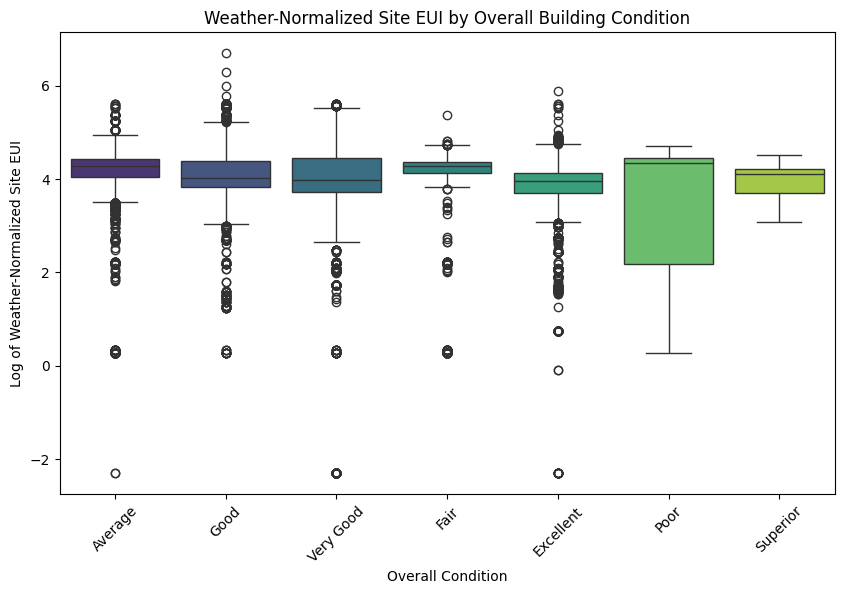

In [ ]:
# Plot weather normalized site energy use intensity by overall condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Condition_OverallCondition', y=np.log(resid_df['Weather Normalized Site EUI (kBtu/ft2)']), data=resid_df, 
            hue='Condition_OverallCondition', palette='viridis', legend=False)
plt.xlabel('Overall Condition')
plt.ylabel('Log of Weather-Normalized Site EUI')
plt.title('Weather-Normalized Site EUI by Overall Building Condition')
plt.xticks(rotation=45)
plt.show()

Site energy use by overall condition of the building. We might want to combine excellent, superior, and very good together.

Let's check the correlations between the predictors. We want to know where we need to adjust for multicollinearity before we do unnecessary exploration.

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
More markers for the different sections would go a long way to making your notebook more readable. This discussion of the correlations is a new section and some indication of that would be very helpful
</div>

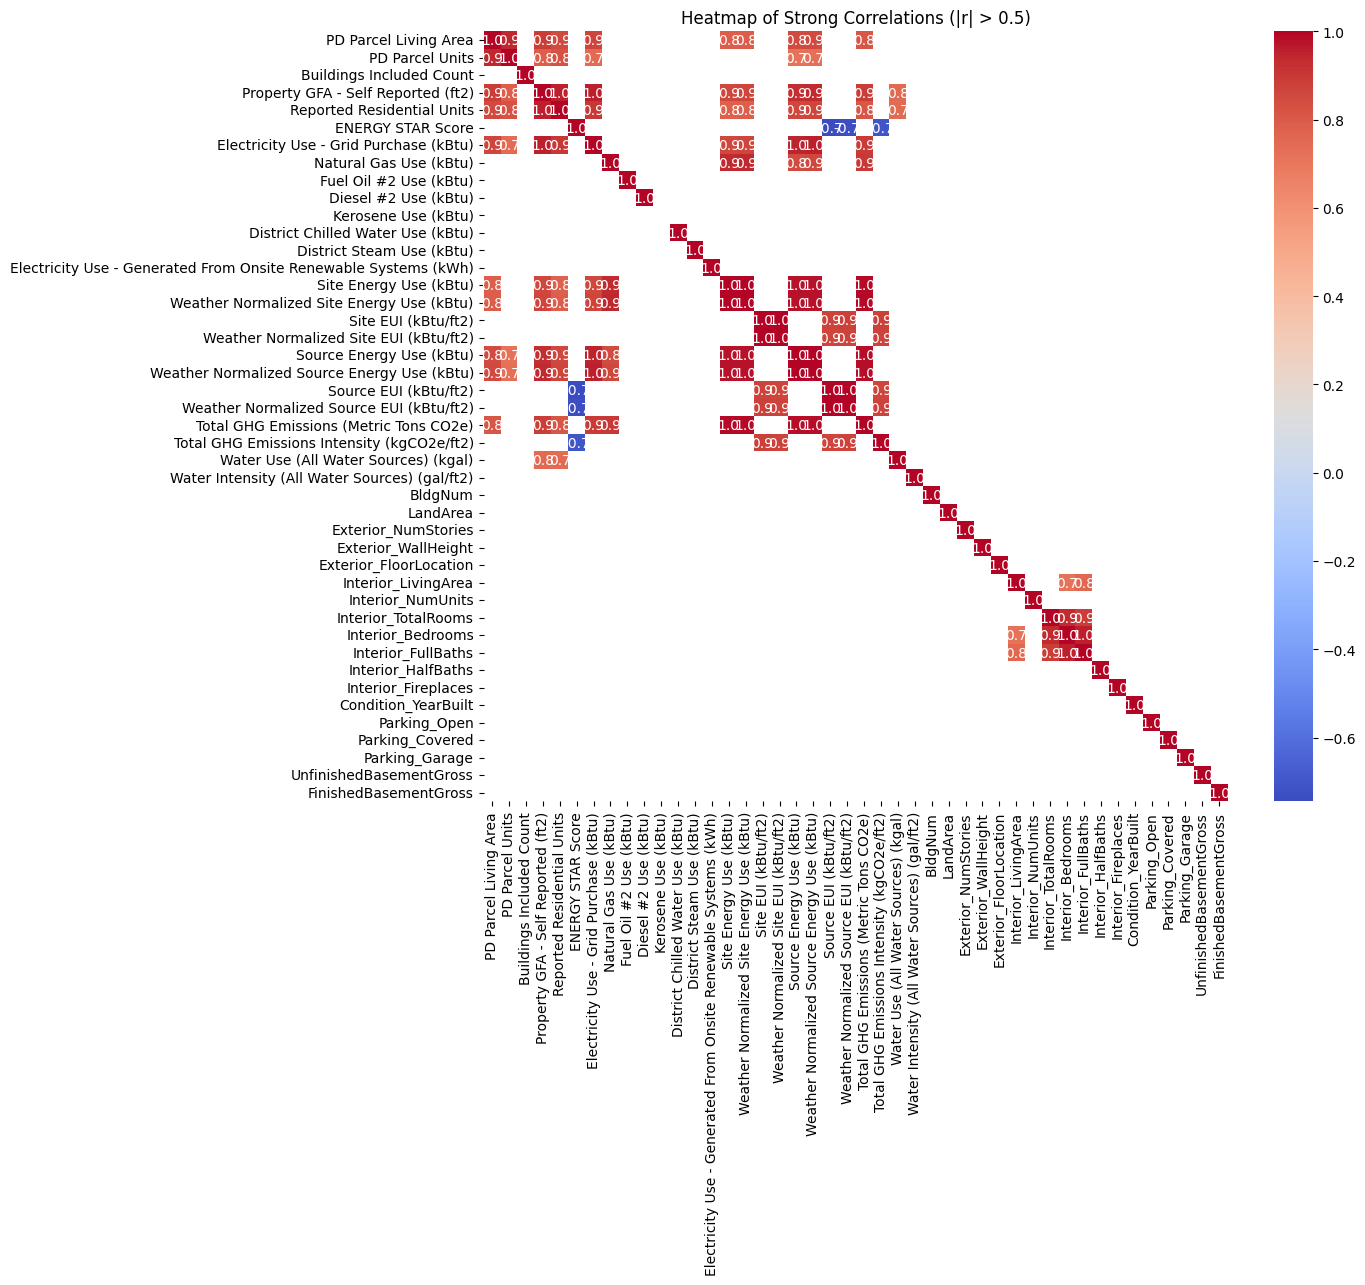

In [ ]:
# Plot correlation heatmap for numerical features
df_num = resid_df.select_dtypes(include=['float64','int'])

correlation_matrix_large = df_num.corr()
# Set threshold 0.7 to be visible on map
threshold = 0.7
strong_corr = correlation_matrix_large[(correlation_matrix_large >= threshold) | (correlation_matrix_large <= -threshold)]

# Plot the heatmap for strong correlations only
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, cmap="coolwarm", fmt=".1f", mask=strong_corr.isnull())
plt.title("Heatmap of Strong Correlations (|r| > 0.5)")
plt.show()

PD parcel living area has strong correlation with PD parcel units, Property GFA selfreported (ftw), Reported Residential units. THere might be multicolieanrity between these features. We will consider drop if it's not improving models.
Additional, it has strong correlation with Electricity use-Grid purchase, site energy use, source energy use, GHG emission.

PD parcel units, Property GFA, reported residential units have similar strong correlation with above energy usage. In addition, there is strong correlation with water usage.

Energy star score has strong negative correlation with the energy use intensity columns.

Electricity use grid purchase has similar correlation with energy use above. 

Interior living area has strong correlation with total bedrooms and bathrooms.

We'll consider handling for these later, during preprocessing. For now, let's take another look at the log of our response variable and see how it compares to the numeric features of our residential dataset.

In [ ]:
# Taking log of Weather Normalized Site EUI
resid_df = resid_df.copy()  # Ensure no SettingWithCopyWarning
resid_df['Log_Weather Normalized Site EUI'] = np.log1p(resid_df['Weather Normalized Site EUI (kBtu/ft2)'])

c:\Users\Z004KYBK\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Z004KYBK\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


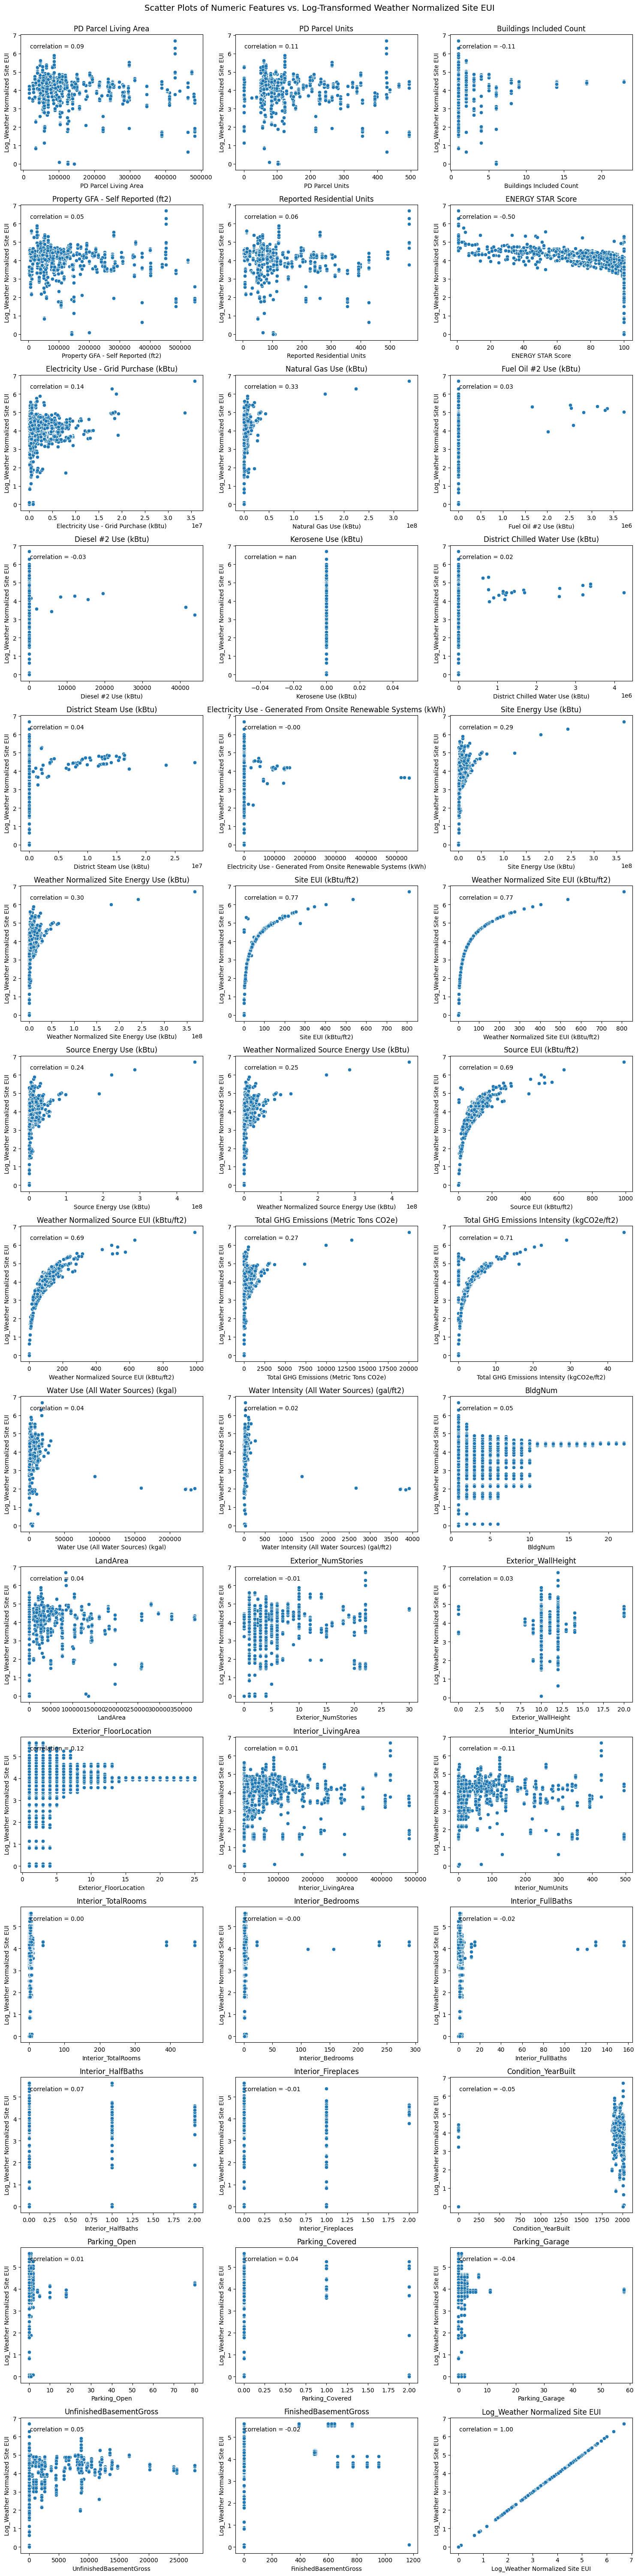

In [ ]:
# Plot numeric features vs log of weather normalized site EUI
numeric_columns = [col for col in resid_df.columns if resid_df[col].dtype in ['int64', 'float64']]

n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() 

for i, col in enumerate(numeric_columns):
    sns.scatterplot(
        ax=axes[i],
        x=resid_df[col],
        y=resid_df['Log_Weather Normalized Site EUI']
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Log_Weather Normalized Site EUI')
    
    correlation = resid_df[col].corr(resid_df['Log_Weather Normalized Site EUI'])
    axes[i].annotate(f'correlation = {correlation:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Scatter Plots of Numeric Features vs. Log-Transformed Weather Normalized Site EUI', 
             fontsize=14, y=1)

plt.tight_layout()
plt.show()

##### Strong Negative Correlations:

- ENERGY STAR Score (-0.50)
- Diesel #2 Use (kBtu) (-0.53) (it's possible that Diesel #2 is used in more efficient systems or as a supplemental fuel in buildings already designed for lower energy consumption. Need to see -> low data)

##### Moderate Positive Correlations:

- Natural Gas Use (kBtu) (0.32)
- District Steam Use (kBtu) (0.32)
- Site Energy Use (kBtu) (0.29)
- Electricity Use - Generated From Onsite Renewable Systems (kWh) (0.29) (this is probably due to the fact buildings having these technologies use large amount of energy overall. Need to see -> low data)
- Weather Normalized Site Energy Use (kBtu) (0.30)
- Total GHG Emissions (Metric Tons CO2e) (0.27)

##### Strong Positive Correlations:

- Site EUI (kBtu/ft2) (0.77)
- Source EUI (kBtu/ft2) (0.69)
- Total GHG Emissions Intensity (kgCO2e/ft2) (0.71)
- Fuel Oil #2 Use (kBtu) (0.90) (Need to see -> low data)

##### Weak or No Correlations:

Most other variables show very weak correlations close to 0, 
small sample sizes for some energy types due to missing data

##### Side notes:
We notice some odd distributions among the predictors.
- Condition_YearBuilt has a number of points with a year of 0, which is nonsensical.
- There are a few observations with disproportionately high parking space counts (presumably parking garages).
- The counts on some of the Interior columns suggest that there are several buildings that do not have unit-level property data but do contain many residential units.

The 0s in Condition_YearBuilt squashed the real values to the right side of the plot, so we'll do another with the 0s excluded.

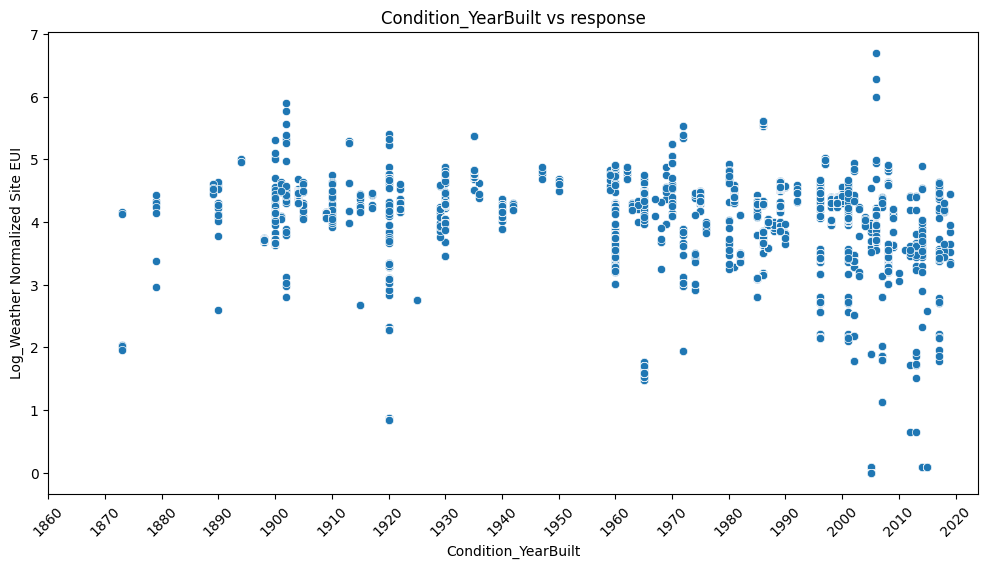

In [ ]:
# Compare Condition_YearBuilt to response
plt.figure(figsize=(12, 6))
sns.scatterplot(x=resid_df['Condition_YearBuilt'], y=resid_df['Log_Weather Normalized Site EUI'])
plt.xlim(1860, 2024)
plt.xticks(ticks=range(1860, 2025, 10), rotation=45)
plt.title('Condition_YearBuilt vs response')
plt.show()

Observation: When analyzing the relationship between the year built and EUI, an interesting trend emerges. From 1850 to 1950, EUI usage increases, while from 1950 to 2024, EUI shows a decline. A gradual change in building priorities? A change in building methods and technology? A change in what types of buildings are being built? Further exploration might tell us, but for now we have other priorities.

Let's check how the categorical features interact with our response variable.

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
This should read like the final version, not an early draft</div>

In [ ]:
# Drop some columns we want to exclude from plotting
resid_df.drop(columns=['Reporting ID','BEUDO Category','Unit'], axis=1,inplace=True)
object_columns = [col for col in resid_df.columns if resid_df[col].dtype in ['object']]

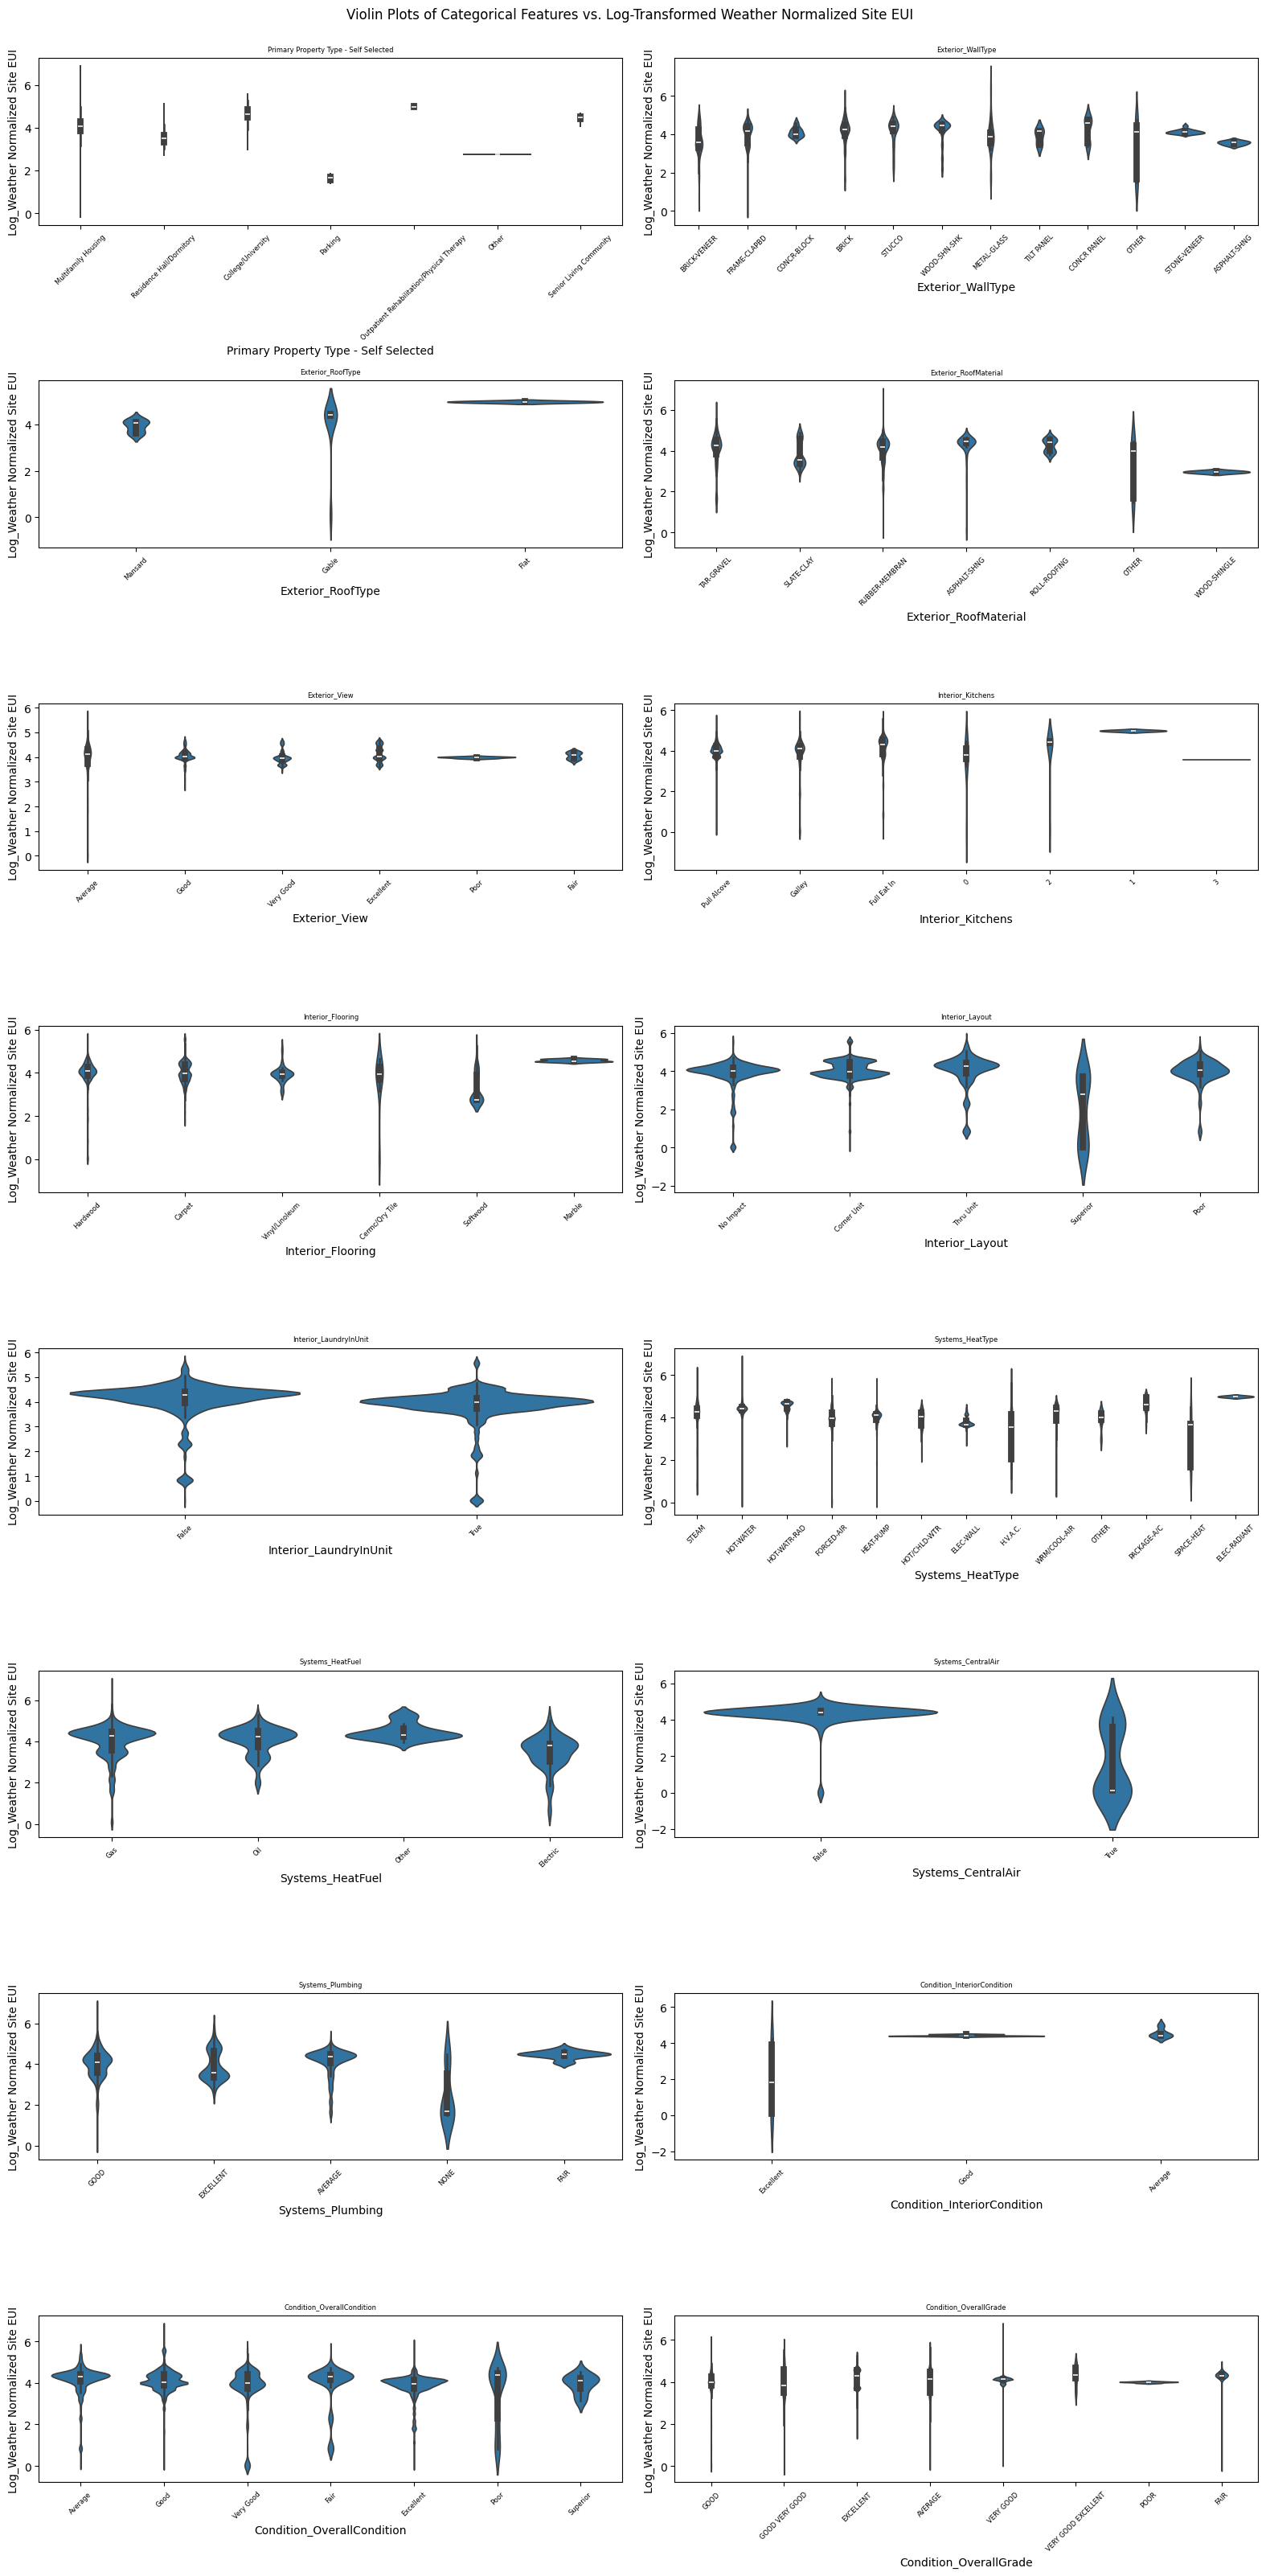

In [ ]:
# Plot categorical features with Normalized site EUI
n_cols = 2
n_rows = math.ceil(len(object_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 4))
axes = axes.flatten() 

for i, col in enumerate(object_columns):
    sns.violinplot(
        ax=axes[i],
        x=resid_df[col],
        y=resid_df['Log_Weather Normalized Site EUI']
    )
    axes[i].set_title(f'{col}',fontsize=6)
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', labelsize=6, rotation=45) 
    axes[i].set_ylabel('Log_Weather Normalized Site EUI')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Violin Plots of Categorical Features vs. Log-Transformed Weather Normalized Site EUI', 
             fontsize=12, y=1)

plt.tight_layout()
plt.show()

Primary Property Type vs Log of Site EUI

Observation: Different property types exhibit distinct distributions of EUI. However, the majority of properties are classified as multifamily housing, with only a few classified as colleges. Multifamily housing spans a broad range of EUI usage.

Exterior Wall Type vs Log of Site EUI

Observation: Brick veneer, metal glass, and asphalt shingle wall types appear to have lower average EUI usage. The "other" category seems to have a large number of data points, which may need further exploration.

Exterior Roof Type vs Log of Site EUI

Observation: Gable and flat roofs appear to have higher EUI usage. However, there seems to be limited data available for these types.

Exterior Roof Material vs Log of Site EUI

Observation: Slate clay and wood shingle roof materials seem to have lower EUI on average. Rubber membrane roofs show higher EUI usage but also contain many outliers.

Exterior View vs Log of Site EUI

Observation: The condition of the exterior view does not appear to significantly impact EUI usage.

Interior Kitchen vs Log of Site EUI

Observation: The kitchen type does not seem to make a notable difference in EUI usage. This category contains both numerical and categorical data. Since it does not show much variation, it can be considered for removal in later analysis.

Interior Flooring vs Log of Site EUI

Observation: Softwood flooring appears to have the lowest EUI usage, but there are some significant outliers at the higher end. Marble flooring tends to have higher EUI on average.

Interior Layout vs Log of Site EUI

Observation: "Thru units" exhibit slightly higher EUI usage compared to other types, while "superior" layouts appear to have lower EUI usage. It is worth exploring what "superior" specifically means in this context. Based on the name, we can assume it refers to the best layout.

Interior Laundry in Units vs Log of Site EUI

Observation: Properties without in-unit laundry have slightly higher EUI usage, but the difference is minimal.

System Heat Type vs Log of Site EUI

Observation: There are several heat types in the raw data. Grouping similar types together might be beneficial. Further EDA should be conducted after data cleaning and imputation.

System Heat Fuel vs Log of Site EUI

Observation: The type of heating fuel does not seem to significantly impact EUI usage on average. However, electric heating shows slightly lower EUI on average.

System Central Air vs Log of Site EUI

Observation: Properties without central air systems tend to have EUI values concentrated around 4,000. Properties with central air systems appear to have lower EUI usage on average, though there is less data available for this category.




## 5. Data preprocessing and engineering (Property aggregation)
The rows for individual buildings and units in the Property Database dataset need to be aggregated up to property level, but they can't all be aggregated in the same way. Some are categorical, some need to be summed, some need to be averaged, and so on. In this section we define what needs to happen to each.

### Explore needed aggregation and imputation

Let's go down the list.
- BldgNum: Building number within the property. Present even if there's only one building. Useful for verifying we don't have duplicates. Will be dropped during aggregation.
- Unit: Unit number within building. NaN if the building doesn't have recorded subunits. Maybe aggregate by this and then aggregate the buildings?
- LandArea: Appears to be land area of the whole parcel? Maybe? The value is shared by all buildings in a parcel, so presumably it's already the aggregate. LandArea is 0 for rows with Unit values. Likely to be problematic for prediction. Probably drop this.
- Exterior_NumStories: For buildings without Units, this is the number of stories the building has. For unit rows, this appears to be the story that unit is on. Take maximum for unit aggregation, take weighted average for building aggregation.
- Exterior_WallType: Take weighted mode. Could say "mixed" if the proportions are pretty even? Always empty for unit data. Could add "apartment/multifamily" category for those.
- Exterior_WallHeight: Average height of floors in the building. Always empty for unit data. Take weighted average for building data. Use median residential floor height for unit data. (12 feet?)
- Exterior_RoofType: While definitely interesting for energy use, almost no rows have values in this column. Too much missing data to be useful. We could impute to some extent from roof material, but it would be so 1:1 that we'd just get multicollinearity. We'll drop this.
- Exterior_RoofMaterial: Very interesting, and a lot of rows have it. Always empty for unit rows. Take weighted mode. If proportions are too similar, set as "MIXED".
- Exterior_FloorLocation: Floor level for condominium units. Always empty for non-unit rows. How this interacts with Exterior_NumStories is unclear. Maybe units with Exterior_NumStories higher than 1 span multiple stories, and Exterior_FloorLocation is what floor they start on? Or what floor the entrance is on? Treatment might not be uniform. Consider taking the maximum of the two columns for each row.
- Exterior_View: Unlikely to be relevant in any meaningful way. Theoretically could mean something about the window quality or placement, but that doesn't seem to be what it's going for. Drop this.
- Interior_LivingArea: Finished area of building. Separate for each unit and building. Useful for weighted aggregation. Aggregate by taking sum. As sanity check, want sum to be similar to PD Parcel Living Area.
- Interior_NumUnits: Number of units in commercial/apartment building. Mutually exclusive with Unit column. Used for properties where data wasn't separately recorded for each unit? Set to 1 for unit rows, then take sum to aggregate to building. For property-level aggregation, could have one column for mean numunits and one for total numunits? Doubt it's an important predictor.
- Interior_TotalRooms: "Total number of rooms in a commercial or residential building". Actual meaning is more ambiguous. There are residential rows with TotalRooms of 0.0. There are non-residential rows with 36 rooms. Unit and non-unit rows both have values for this column. Needs deeper investigation. To aggregate, take sum.
- Interior_Bedrooms: Total bedroom count. Take sum.
- Interior_Kitchens: Confused mix of kitchen types and counts of kitchens. Kitchen types are likely irrelevant. Convert kitchen types to 1, then aggregate via sum.
- Interior_FullBaths: Full bathroom count (i.e. bathrooms with all of toilet, sink, bathtub, shower). Take sum. Most non-unit rows have NA for this column. Probably impute from other columns.
- Interior_HalfBaths: Half bathroom count (i.e. bathrooms with only toilet and sink). Take sum. Can impute as with FullBaths.
- Interior_Fireplaces: Aggregate via sum.
- Interior_Flooring: Weighted mode. If similar proportions, use "Mixed".
- Interior_Layout: Only relevant to condo units. Could have impact on individual condo unit energy use, but we don't measure that. Drop.
- Interior_LaundryInUnit: Only relevant to condo units. Can sum to get total laundry machine count, but realistically it doesn't give us anything useful, not least because there can be a shared laundry that this variable doesn't catch. Plus, as long as there's laundry in the building, likelihood is that water/energy use will be the same as it would be for in-unit laundry. Drop.
- Systems_HeatType: Few missing values. Need to correct some entries (use the capitalized categories). Take weighted mode, as per usual. Try to impute missing values.
- Systems_HeatFuel: Not a lot of good values in this column. May be imputable from fuel use columns in energy use dataset. If we keep this, take weighted mode.
- Systems_CentralAir: Almost no values for this column. Not imputable, as much as I wish it were. Drop.
- Systems_Plumbing: Rating of plumbing system. Unclear what this means in practical terms. Seems to just be plumbing condition? Investigation shows that while plumbing condition has no strong relationship with energy use, plumbing of "None" tends to mean significantly lower energy use. Turn into a binary plumbing or no plumbing, then take weighted average when aggregating.
- Condition_YearBuilt: Year the building was built. Some rows have 0s for some reason. Matches Year Built for nearly all rows, but there are a few anomalies that need closer inspection. Handle those anomalies, then drop in favor of Data Year.
- Condition_InteriorCondition: Very few rows have this filled in. Not usefully imputable. Drop.
- Condition_OverallCondition: Has values for almost all rows. Impute or drop remainder. Need to figure out what "superior" rating means. Ordinal, so take weighted median. May convert to numeric?
- Condition_OverallGrade: Almost no missing values. Impute or drop remainder. Need to clean up categories, unify on capitalized category names. Ordinal, so take weighted median. May convert to numeric?
- Parking_Open: Number of open parking spaces for residential building or condo unit. I can't imagine this has any impact on energy use. Recommend drop.
- Parking_Covered: Number of covered parking spaces for residential building or condo unit. Probably low impact on energy use, but maybe some. Nearly all rows have NA or 0, a few have 1 or 2, five have 45. _Extremely_ likely to cause overfitting. Recommend drop.
- Parking_Garage: Number of garage parking spaces for residential building or condominium unit. Wild variety in values. At least one of the buildings in the dataset is a 99-car parking garage. I don't know what to do with that. Leave it in, I guess? If we're looking at only residential buildings, we still get at least one building which has an internal garage that's marked as a unit (G1). Aggregate via sum.
- UnfinishedBasementGross: Not included in metadata spreadsheet, but presumably is total amount of basement without finishing (wood, flooring, etc.). Aggregate via sum.
- FinishedBasementGross: Not included in metadata spreadsheet, but presumably is total amount of basement with finishing (wood, flooring, etc.). Aggregate via sum.

Note: Weighting is, if possible, by Interior_LivingArea and Exterior_WallHeight. Larger buildings and units will have greater impact on the overall property energy use. Where Exterior_WallHeight is not available, it's acceptable to weight by Interior_LivingArea alone.

Now that we've made our plans for cleaning up the Property Database columns, we need to implement them.

### Clean and impute missing values
We'll start by dropping a number of columns that we've determined are either irrelevant, redundant, or too sparse to use.

In [ ]:
# Drop unwanted columns
property_dropcols = ['LandArea', 'Exterior_RoofType', 'Exterior_View', 'Interior_Layout', 'Interior_LaundryInUnit', 'Systems_CentralAir',
                     'Condition_InteriorCondition', 'Parking_Open', 'Parking_Covered']
merged_clean = merged_data.drop(property_dropcols, axis=1)
merged_clean.head()

Reporting ID  Data Year   BEUDO Category  PD Parcel Living Area  \
0        B1600 2016-01-01  Non-Residential                57000.0   
1        B1360 2017-01-01  Non-Residential              1462119.0   
2        B1360 2017-01-01  Non-Residential              1462119.0   
3        B1360 2017-01-01  Non-Residential              1462119.0   
4        B1360 2017-01-01  Non-Residential              1462119.0   

   PD Parcel Units Year Built  Buildings Included Count  \
0              1.0 1910-01-01                         1   
1             18.0 2010-01-01                         1   
2             18.0 2010-01-01                         1   
3             18.0 2010-01-01                         1   
4             18.0 2010-01-01                         1   

  Primary Property Type - Self Selected  Property GFA - Self Reported (ft2)  \
0                                Office                             38000.0   
1                               Parking                            223000.0   
2                               Parking                            223000.0   
3                               Parking                            223000.0   
4                               Parking                            223000.0   

   Reported Residential Units  ENERGY STAR Score  \
0                         0.0                NaN   
1                         0.0                NaN   
2                         0.0                NaN   
3                         0.0                NaN   
4                         0.0                NaN   

   Electricity Use - Grid Purchase (kBtu)  Natural Gas Use (kBtu)  \
0                                 32880.5                     0.0   
1                               1876014.7                     0.0   
2                               1876014.7                     0.0   
3                               1876014.7                     0.0   
4                               1876014.7                     0.0   

   Fuel Oil #2 Use (kBtu)  Diesel #2 Use (kBtu)  Kerosene Use (kBtu)  \
0                     0.0                   0.0                  0.0   
1                     0.0                   0.0                  0.0   
2                     0.0                   0.0                  0.0   
3                     0.0                   0.0                  0.0   
4                     0.0                   0.0                  0.0   

   District Chilled Water Use (kBtu)  District Steam Use (kBtu)  \
0                                0.0                        0.0   
1                                0.0                        0.0   
2                                0.0                        0.0   
3                                0.0                        0.0   
4                                0.0                        0.0   

   Electricity Use - Generated From Onsite Renewable Systems (kWh)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

   Site Energy Use (kBtu)  Weather Normalized Site Energy Use (kBtu)  \
0                 32880.5                                    32880.5   
1               1876014.7                                  1876014.7   
2               1876014.7                                  1876014.7   
3               1876014.7                                  1876014.7   
4               1876014.7                                  1876014.7   

   Site EUI (kBtu/ft2)  Weather Normalized Site EUI (kBtu/ft2)  \
0                  0.9                                     0.9   
1                  8.4                                     8.4   
2                  8.4                                     8.4   
3                  8.4                                     8.4   
4        

Next, we'll consolidate kitchen types so it can be used as a numeric feature, then convert plumbing to a simple "has/doesn't have plumbing" binary.

In [ ]:
# Convert kitchen types to 1
merged_clean['Interior_Kitchens'] = [1 if x in ['Pull Alcove', 'Galley', 'Full Eat In'] else x for x in merged_clean.Interior_Kitchens]
merged_clean['Interior_Kitchens'] = [0 if x in ["None", None, "0"] else x for x in merged_clean.Interior_Kitchens]
merged_clean['Interior_Kitchens'] = pd.to_numeric(merged_clean['Interior_Kitchens'], errors='coerce')

# Convert plumbing to binary
merged_clean.loc[(merged_clean['Systems_Plumbing'] != "NONE") & merged_clean.Systems_Plumbing.notna(), 'Systems_Plumbing'] = 1
merged_clean.loc[merged_clean['Systems_Plumbing'] == "NONE", 'Systems_Plumbing'] = 0

Rows with a Unit value don't necessarily have a NumUnits value. Since we'll be aggregating them to building level and then using them alongside rows that do have NumUnits counts, we'll fill all rows with a Unit value to have a NumUnits of 1. We'll sum during aggregation to get the number of units for the building.

In [ ]:
# Set Interior_NumUnits to 1 for unit rows.
merged_clean.loc[merged_clean.Unit.notna() & merged_clean.Interior_NumUnits.isna(), 'Interior_NumUnits'] = 1

Next item. There are 56 rows with 0 in Condition_YearBuilt. The lots containing these observations have similar Condition_YearBuilt values, so we impute using the mode of Condition_YearBuilt for the same lot. Reporting IDs with no Condition_YearBuilt values are imputed with the overall mode.

In [ ]:
# Add column marking that values were/will be imputed
merged_clean['Imputed_Condition_YearBuilt'] = [1 if x == 0 else 0 for x in merged_clean['Condition_YearBuilt']]

# Impute Condition_YearBuilt zeros with mode of same reporting ID
for rid in merged_clean['Reporting ID'].unique():
    group = merged_clean.loc[merged_clean['Reporting ID'] == rid]
    year_built_mode = group['Condition_YearBuilt'].mode()[0]
    merged_clean.loc[(merged_clean['Reporting ID'] == rid) & (merged_clean['Condition_YearBuilt'] == 0), 'Condition_YearBuilt'] = year_built_mode

In [ ]:
# Impute remaining zeros with the overall mode
overall_mode = int(merged_clean['Condition_YearBuilt'].mode()[0])
merged_clean.loc[merged_clean['Condition_YearBuilt'] == 0, 'Condition_YearBuilt'] = overall_mode

If possible, we'd like to impute Exterior_WallType. Unfortunately, we are seeing that the majority of Residential rows don't have values for this column. For commercial or industrial buildings, exterior wall types might be documented due to structural and regulatory reasons (e.g., compliance with fire safety or energy efficiency standards). For residential buildings, especially small-scale or multi-family homes, this data might not be routinely recorded. This could explain why Exterior_WallType is often missing for "Residential."

We did the chi-square test to verify if there is association between wall type and property type so we can use that to compute the missing. If p value is less than 0.05, it means there is strong association between exterior wall type and property type.

In [ ]:
# Check count of NA values in roof material by BEUDO category
na_counts2 = merged_clean.groupby('BEUDO Category')['Exterior_RoofMaterial'].apply(lambda x: x.isna().sum())
na_counts2

BEUDO Category
Municipal              1
Non-Residential     4241
Residential        27958
Name: Exterior_RoofMaterial, dtype: int64

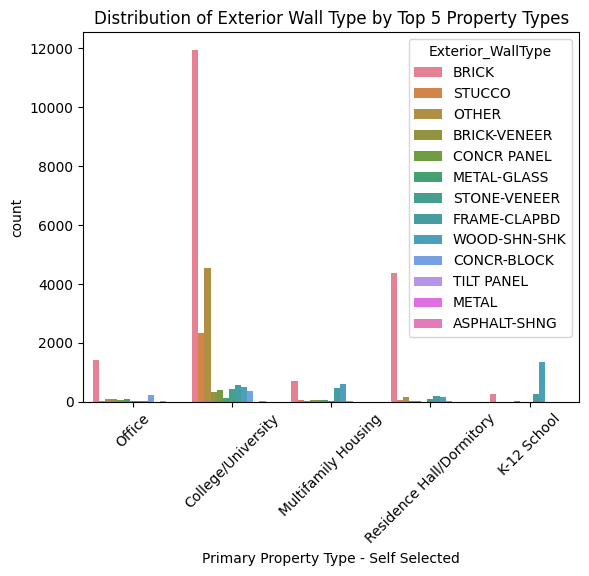

Chi-Square Test Statistic: 30020.532
P-Value: 0.000


In [ ]:
# Plot the distribution of Exterior_WallType across Property Type
top_property_types = merged_clean['Primary Property Type - Self Selected'].value_counts().head(5).index
filtered_data = merged_clean[merged_clean['Primary Property Type - Self Selected'].isin(top_property_types)]

# Create the count plot
sns.countplot(
    data=filtered_data,
    x='Primary Property Type - Self Selected',
    hue='Exterior_WallType'
)
plt.xticks(rotation=45)
plt.title("Distribution of Exterior Wall Type by Top 5 Property Types")
plt.show()

# Perform the chi-square test, if p value is less than 0, it means there is strong association between exterior wall type and property type 
non_missing_data = merged_clean[merged_clean['Exterior_WallType'].notna()]
contingency_table = pd.crosstab(non_missing_data['Primary Property Type - Self Selected'], non_missing_data['Exterior_WallType'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print test statistics
print(f"Chi-Square Test Statistic: {chi2:.3f}")
print(f"P-Value: {p:.3f}")

There is clearly a strong relationship between property type and exterior wall type. We may be able to use this to get better imputation of wall type. We'll define a function to calculate the mode for each property type, defaulting to "OTHER" if no better option is available. In keeping with best practices, we will also add a column indicating whether Exterior_WallType was imputed.

In [ ]:
# Define a function to handle mode calculation with a fallback
def get_mode_or_default(series, default="OTHER"):
    return series.mode()[0] if not series.mode().empty else default

# Calculate the most common wall type (mode) for each property type
wall_type_mode_by_property = merged_clean.groupby('Primary Property Type - Self Selected')['Exterior_WallType'].agg(lambda x: get_mode_or_default(x))

# Add column marking that values were/will be imputed
merged_clean['Imputed_Exterior_WallType'] = pd.isna(merged_clean['Exterior_WallType']).astype(int)

# Impute missing values with the mode of the corresponding property type
merged_clean['Exterior_WallType'] = merged_clean.apply(
    lambda row: wall_type_mode_by_property[row['Primary Property Type - Self Selected']] 
    if pd.isna(row['Exterior_WallType']) else row['Exterior_WallType'], 
    axis=1
)

In [ ]:
# Check updated value counts
merged_clean['Exterior_WallType'].value_counts()

Exterior_WallType
BRICK           52907
OTHER            5117
WOOD-SHN-SHK     2799
STUCCO           2568
FRAME-CLAPBD     1686
CONCR-BLOCK      1173
CONCR PANEL       819
STONE-VENEER      748
BRICK-VENEER      721
METAL-GLASS       388
METAL             113
TILT PANEL         12
ASPHALT-SHNG        3
ASBSTOS-SHNG        2
Name: count, dtype: int64

Those last three categories have too few observations. They'll just overfit. We'll join them to OTHER.

In [ ]:
# Join last three categories to OTHER
merged_clean['Exterior_WallType'] = ['OTHER' if x in ['ASPHALT-SHNG','ASBSTOS-SHNG','TILT PANEL'] else x for x in merged_clean['Exterior_WallType']]

Given the noted relationships, we'll impute missing roof materials by both primary property type and exterior wall type.We can apply a similar approach to Exterior_RoofMaterial, but it looks like Exterior_RoofMaterial has association with both property type and exterior wall type. 

In [ ]:
# Make values to fill in missing roof materials
roof_mode_by_combination = merged_clean.groupby(['Primary Property Type - Self Selected', 'Exterior_WallType'])['Exterior_RoofMaterial'].agg(lambda x: x.mode()[0] if not x.mode().empty else "OTHER")

# Add column marking that values were/will be imputed
merged_clean['Imputed_Exterior_RoofMaterial'] = pd.isna(merged_clean['Exterior_RoofMaterial']).astype(int)

# Impute missing values
merged_clean['Exterior_RoofMaterial'] = merged_clean.apply(
    lambda row: roof_mode_by_combination.get((row['Primary Property Type - Self Selected'], row['Exterior_WallType']), "OTHER")
    if pd.isna(row['Exterior_RoofMaterial']) else row['Exterior_RoofMaterial'],
    axis=1
)

In [ ]:
# Check roof material values after imputation
merged_clean['Exterior_RoofMaterial'].value_counts()

Exterior_RoofMaterial
TAR-GRAVEL        41955
SLATE-CLAY        11910
RUBBER-MEMBRAN     3997
METAL              3635
ROLL-ROOFING       3047
ASPHALT-SHNG       2768
OTHER              1175
WOOD-SHINGLE        218
TILE                215
COMPOSITION         136
Name: count, dtype: int64

There are a few low-prevalence categories remaining, but none so low that they should suffer terrible overfitting. On to the next item.

The Condition columns are currently ordinal text columns. We want to make them numeric so the model can treat them as ordinal. By our previous exploration, the "Superior" category seems to have similar energy use intensities to "Good", so for simplicity and clarity we'll merge those groups together.

In [ ]:
merged_clean.Condition_OverallCondition.value_counts(dropna=False)

Condition_OverallCondition
Excellent    18873
Good         18555
Very Good    16364
Average      13158
Fair          1578
Poor           213
Superior       174
NaN            141
Name: count, dtype: int64

In [ ]:
# "Superior" seems redundant and unclear, so we'll merge it with "Good"
merged_clean['Condition_OverallCondition'] = ['Good' if x == 'Superior' else x for x in merged_clean.Condition_OverallCondition]

# Impute missing with most common category for same reporting ID
merged_clean.reset_index(drop=True, inplace=True)
merged_clean['Imputed_OverallCondition'] = merged_clean.Condition_OverallCondition.isna().astype(int)
for i in range(merged_clean.shape[0]):
    if pd.isna(merged_clean.loc[i, 'Condition_OverallCondition']):
        merged_clean.loc[i, 'Condition_OverallCondition'] = get_mode_or_default(merged_clean.loc[merged_clean['Reporting ID'] == merged_clean.loc[i, 'Reporting ID'], 'Condition_OverallCondition'], 'Good')

# Convert Condition_OverallCondition to numeric
condition_order = ['Poor', 'Fair', 'Average', 'Good', 'Very Good', 'Excellent']
merged_clean['Condition_OverallCondition'] = [condition_order.index(x) for x in merged_clean.Condition_OverallCondition]

In [ ]:
merged_clean.Condition_OverallGrade.value_counts(dropna=False)

Condition_OverallGrade
GOOD                   24379
VERY GOOD              14509
EXCELLENT               9731
AVERAGE                 8705
GOOD VERY GOOD          8661
VERY GOOD EXCELLENT     1628
FAIR                     728
SPECIAL                  630
POOR                      68
NaN                       17
Name: count, dtype: int64

Grade has a "special" category that doesn't fit into the main ordering. Let's see how it compares to the other categories.

c:\Users\Z004KYBK\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


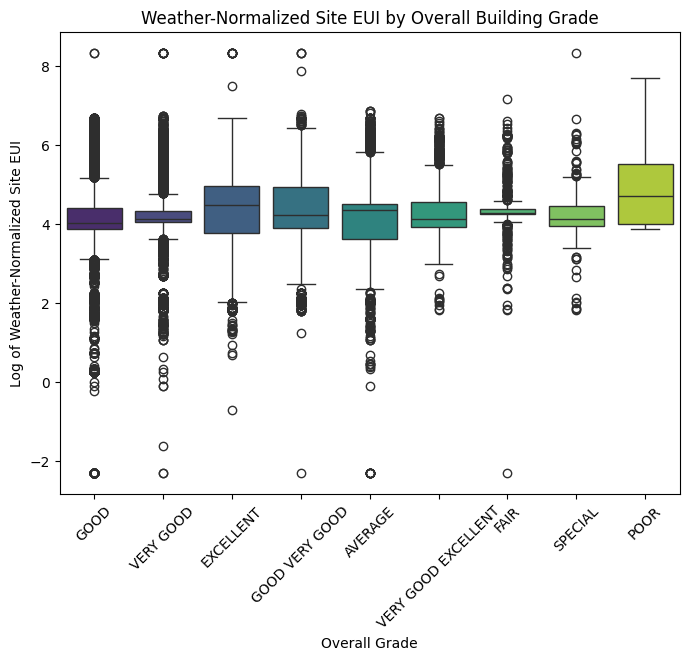

In [ ]:
# Plot weather normalized site energy use intensity by overall condition
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition_OverallGrade', y=np.log(merged_clean['Weather Normalized Site EUI (kBtu/ft2)']), data=merged_clean, 
            hue='Condition_OverallGrade', palette='viridis', legend=False)
plt.xlabel('Overall Grade')
plt.ylabel('Log of Weather-Normalized Site EUI')
plt.title('Weather-Normalized Site EUI by Overall Building Grade')
plt.xticks(rotation=45)
plt.show()

It seems like SPECIAL is pretty much equivalent to VERY GOOD EXCELLENT. For clarity, we'll merge the former into the latter.

In [ ]:
# Apply the same procedure to Condition_OverallGrade

# Replace SPECIAL with VERY GOOD EXCELLENT
merged_clean['Condition_OverallGrade'] = ['VERY GOOD EXCELLENT' if x == 'SPECIAL' else x for x in merged_clean.Condition_OverallGrade]

# Impute missing with most common category for same reporting ID
merged_clean.reset_index(drop=True, inplace=True)
merged_clean['Imputed_OverallGrade'] = merged_clean.Condition_OverallGrade.isna().astype(int)
for i in range(merged_clean.shape[0]):
    if pd.isna(merged_clean.loc[i, 'Condition_OverallGrade']):
        merged_clean.loc[i, 'Condition_OverallGrade'] = get_mode_or_default(merged_clean.loc[merged_clean['Reporting ID'] == merged_clean.loc[i, 'Reporting ID'], 'Condition_OverallGrade'], 'GOOD')

# Convert Condition_OverallGrade to numeric
grade_order = ['POOR', 'FAIR', 'AVERAGE', 'GOOD', 'GOOD VERY GOOD', 'VERY GOOD', 'VERY GOOD EXCELLENT', 'EXCELLENT']
merged_clean['Condition_OverallGrade'] = [grade_order.index(x) for x in merged_clean.Condition_OverallGrade]

In [ ]:
# Check that the modified columns have come out as intended
merged_clean.head()

Reporting ID  Data Year   BEUDO Category  PD Parcel Living Area  \
0        B1600 2016-01-01  Non-Residential                57000.0   
1        B1360 2017-01-01  Non-Residential              1462119.0   
2        B1360 2017-01-01  Non-Residential              1462119.0   
3        B1360 2017-01-01  Non-Residential              1462119.0   
4        B1360 2017-01-01  Non-Residential              1462119.0   

   PD Parcel Units Year Built  Buildings Included Count  \
0              1.0 1910-01-01                         1   
1             18.0 2010-01-01                         1   
2             18.0 2010-01-01                         1   
3             18.0 2010-01-01                         1   
4             18.0 2010-01-01                         1   

  Primary Property Type - Self Selected  Property GFA - Self Reported (ft2)  \
0                                Office                             38000.0   
1                               Parking                            223000.0   
2                               Parking                            223000.0   
3                               Parking                            223000.0   
4                               Parking                            223000.0   

   Reported Residential Units  ENERGY STAR Score  \
0                         0.0                NaN   
1                         0.0                NaN   
2                         0.0                NaN   
3                         0.0                NaN   
4                         0.0                NaN   

   Electricity Use - Grid Purchase (kBtu)  Natural Gas Use (kBtu)  \
0                                 32880.5                     0.0   
1                               1876014.7                     0.0   
2                               1876014.7                     0.0   
3                               1876014.7                     0.0   
4                               1876014.7                     0.0   

   Fuel Oil #2 Use (kBtu)  Diesel #2 Use (kBtu)  Kerosene Use (kBtu)  \
0                     0.0                   0.0                  0.0   
1                     0.0                   0.0                  0.0   
2                     0.0                   0.0                  0.0   
3                     0.0                   0.0                  0.0   
4                     0.0                   0.0                  0.0   

   District Chilled Water Use (kBtu)  District Steam Use (kBtu)  \
0                                0.0                        0.0   
1                                0.0                        0.0   
2                                0.0                        0.0   
3                                0.0                        0.0   
4                                0.0                        0.0   

   Electricity Use - Generated From Onsite Renewable Systems (kWh)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

   Site Energy Use (kBtu)  Weather Normalized Site Energy Use (kBtu)  \
0                 32880.5                                    32880.5   
1               1876014.7                                  1876014.7   
2               1876014.7                                  1876014.7   
3               1876014.7                                  1876014.7   
4               1876014.7                                  1876014.7   

   Site EUI (kBtu/ft2)  Weather Normalized Site EUI (kBtu/ft2)  \
0                  0.9                                     0.9   
1                  8.4                                     8.4   
2                  8.4                                     8.4   
3                  8.4                                     8.4   
4        

With those items made usable, we move on to the next task.

In [ ]:
# Check remaining NAs
na_counts = merged_clean.isna().sum()
na_counts[na_counts > 0]

PD Parcel Units                                   2715
Property GFA - Self Reported (ft2)                  58
Reported Residential Units                         966
ENERGY STAR Score                                26809
Electricity Use - Grid Purchase (kBtu)            1248
Weather Normalized Site Energy Use (kBtu)         6696
Weather Normalized Site EUI (kBtu/ft2)            6393
Weather Normalized Source Energy Use (kBtu)       6696
Weather Normalized Source EUI (kBtu/ft2)          6393
Water Use (All Water Sources) (kgal)              6700
Water Intensity (All Water Sources) (gal/ft2)     8375
Unit                                             37114
Exterior_WallHeight                              32146
Exterior_FloorLocation                           37958
Interior_TotalRooms                              36910
Interior_Bedrooms                                36910
Interior_Kitchens                                39728
Interior_FullBaths                               36910
Interior_H

Remaining aggregation and imputation:
    
    Exterior_NumStories: For buildings without Units, this is the number of stories the building has. For unit rows, this appears to be the story that unit is on. Take maximum for unit aggregation, take weighted average for building aggregation.
    
    Interior_Flooring: Weighted mode. If similar proportions, use "Mixed".
    
    Systems_HeatType: Few missing values. Take weighted mode, as per usual. Try to impute missing values.
    
    Systems_HeatFuel: Not a lot of good values in this column. May be imputable from fuel use columns in energy use dataset. If we keep this, take weighted mode.
    
    Exterior_WallHeight: Average height of floors in the building. Always empty for unit data. Take weighted average for building data. Use median residential floor height for unit data. (12 feet?)
    Systems_Plumbing: After correction, take weighted average.
    
    Interior_LivingArea: Finished area of building. Separate for each unit and building. Useful for weighted aggregation. Aggregate by taking sum. As sanity check, want sum to be similar to PD Parcel Living Area.
    Interior_TotalRooms: "Total number of rooms in a commercial or residential building". Actual meaning is more ambiguous. There are residential rows with TotalRooms of 0.0. There are non-residential rows with 36 rooms. Unit and non-unit rows both have values for this column. Needs deeper investigation. To aggregate, take sum.
    
    Parking_Garage: Number of garage parking spaces for residential building or condominium unit. Wild variety in values. At least one of the buildings in the dataset is a 99-car parking garage. I don't know what to do with that. Leave it in, I guess? If we're looking at only residential buildings, we still get at least one building which has an internal garage that's marked as a unit (G1). Aggregate via sum.
    
    Interior_NumUnits: take sum to aggregate to building. For property-level aggregation, could have one column for mean numunits and one for total numunits? Doubt it's an important predictor.

Columns to drop:

    Drop, as not important! Exterior_FloorLocation: Floor level for condominium units. Always empty for non-unit rows. How this interacts with Exterior_NumStories is unclear. Maybe units with Exterior_NumStories higher than 1 span multiple stories, and Exterior_FloorLocation is what floor they start on? Or what floor the entrance is on? Treatment might not be uniform. Consider taking the maximum of the two columns for each row.
    
    Drop, as not important! Interior_FullBaths: Full bathroom count (i.e. bathrooms with all of toilet, sink, bathtub, shower). Take sum. Most non-unit rows have NA for this column. Probably impute from other columns.
    
    Drop, as not important! Interior_HalfBaths: Half bathroom count (i.e. bathrooms with only toilet and sink). Take sum. Can impute as with FullBaths.
    
    Drop, as not important! Interior_Kitchens: Confused mix of kitchen types and counts of kitchens. Kitchen types are likely irrelevant. then aggregate via sum.

We also note that we still have a number of rows with Site EUI but no Weather Normalized Site EUI. We should be able to impute the latter by finding the year-specific normalization coefficient among the rows we do have normalized data for.

In [ ]:
# Impute weather-normalized site EUI for rows that only have non-normalized
# Framework suggested by ChatGPT

# Step 1: Calculate normalization coefficients
# Filter rows with non-missing values for both Site EUI and Weather-Normalized Site EUI
merged_clean_valid = merged_clean.dropna(subset=['Site EUI (kBtu/ft2)', 'Weather Normalized Site EUI (kBtu/ft2)'])

# Calculate normalization coefficient for each year
coefficients = merged_clean_valid.groupby('Data Year').apply(
    lambda group: (group['Weather Normalized Site EUI (kBtu/ft2)'] / group['Site EUI (kBtu/ft2)']).mean(),
    include_groups=False
).to_dict()

# Step 2: Impute missing values
def impute_weather_normalized(row):
    if pd.isna(row['Weather Normalized Site EUI (kBtu/ft2)']):
        return row['Site EUI (kBtu/ft2)'] * coefficients.get(row['Data Year'], 1)  # Default coefficient of 1 if year is missing
    return row['Weather Normalized Site EUI (kBtu/ft2)']

merged_clean['Weather Normalized Site EUI (kBtu/ft2)'] = merged_clean.apply(impute_weather_normalized, axis=1)

### Aggregate
Now that imputation is sufficiently complete, we will move on to aggregation. The types of aggregation needed vary. Some need weighted medians, some need sums, some need weighted modes, and so on. In order to account for the differing sizes of the buildings or units in a map lot, we weight them by their internal living area.

In [ ]:
# Take sums of columns that need that
sumcols = ['Interior_LivingArea', 'Interior_TotalRooms', 'Interior_Bedrooms', 'Interior_Kitchens', 'Interior_Fireplaces', 
           'Parking_Garage', 'UnfinishedBasementGross', 'FinishedBasementGross', 'Interior_NumUnits']
aggdf = merged_clean.groupby(['Reporting ID', 'Data Year', 'BldgNum'])[sumcols].agg('sum').reset_index()
aggdf.Interior_Kitchens = aggdf.Interior_Kitchens.astype('int32')
aggdf.head(10)

Reporting ID  Data Year  BldgNum  Interior_LivingArea  Interior_TotalRooms  \
0        B1000 2016-01-01        1               144489                  0.0   
1        B1000 2017-01-01        1               144489                  0.0   
2        B1000 2018-01-01        1               144489                  0.0   
3        B1000 2019-01-01        1               144489                  0.0   
4        B1000 2020-01-01        1               144489                  0.0   
5        B1000 2021-01-01        1               144489                  0.0   
6        B1000 2022-01-01        1               144489                  0.0   
7        B1001 2016-01-01        1                57545                  0.0   
8        B1001 2017-01-01        1                57545                  0.0   
9        B1001 2018-01-01        1                57545                  0.0   

   Interior_Bedrooms  Interior_Kitchens  Interior_Fireplaces  Parking_Garage  \
0                0.0                  0                  0.0             0.0   
1                0.0                  0                  0.0             0.0   
2                0.0                  0                  0.0             0.0   
3                0.0                  0                  0.0             0.0   
4                0.0                  0                  0.0             0.0   
5                0.0                  0                  0.0             0.0   
6                0.0                  0                  0.0             0.0   
7                0.0                  0                  0.0             0.0   
8                0.0                  0                  0.0             0.0   
9                0.0                  0                  0.0             0.0   

   UnfinishedBasementGross  FinishedBasementGross  Interior_NumUnits  
0                    43563                    0.0                0.0  
1                    43563                    0.0                0.0  
2                    43563                    0.0                0.0  
3                    43563                    0.0                0.0  
4                    43563                    0.0                0.0  
5                    43563                    0.0                0.0  
6                    43563                    0.0                0.0  
7                        0                    0.0               51.0  
8                        0                    0.0               51.0  
9                        0                    0.0               51.0

In [ ]:
# Define function to calculate weighted medians
# From https://stackoverflow.com/a/73905572, fixed by ChatGPT
def weighted_median(values, weights):
    i = np.argsort(values)  # Sort values and get sorted indices
    sorted_values = values.iloc[i]  # Reorder values using the sorted indices
    c = np.cumsum(weights.iloc[i])  # Cumulative sum of sorted weights
    median_index = np.searchsorted(c, 0.5 * c.iloc[-1])  # Find the median index
    return sorted_values.iloc[median_index]  # Return the value at the median index

# Take weighted medians of columns that need that
weighted_mediancols = ['Condition_OverallCondition', 'Condition_OverallGrade']
groupby_cols = ['Reporting ID', 'Data Year', 'BldgNum']
for col in weighted_mediancols:
    result = merged_clean.groupby(groupby_cols).apply(
        lambda x: weighted_median(x[col], x['Interior_LivingArea']),
        include_groups=False
        ).reset_index(name='Weighted_Median')
    aggdf[col] = result['Weighted_Median']

In [ ]:
# Function to compute weighted mode
# From ChatGPT: "Get the weighted mode of a categorical column in pandas."
def weighted_mode(category, weight):
    # Combine categories and weights
    counts = Counter()
    for cat, w in zip(category, weight):
        counts[cat] += w
    # Find the mode(s) with the highest weight
    max_weight = max(counts.values())
    mode = [key for key, val in counts.items() if val == max_weight]
    return mode[0]  # Return the first mode in case of ties
    
# Take weighted mode of columns that need that
weighted_modecols = ['Exterior_WallType', 'Exterior_RoofMaterial', 'Interior_Flooring', 'Systems_HeatType', 'Systems_HeatFuel',
                     'Imputed_Exterior_RoofMaterial', 'Imputed_Condition_YearBuilt', 'Imputed_Exterior_WallType', 'Imputed_OverallCondition',
                     'Imputed_OverallGrade']
groupby_cols = ['Reporting ID', 'Data Year', 'BldgNum']
for col in weighted_modecols:
    result = merged_clean.groupby(groupby_cols).apply(
        lambda x: weighted_mode(x[col], x['Interior_LivingArea']),
        include_groups=False
        ).reset_index(name='Weighted_Mode')
    aggdf[col] = result['Weighted_Mode']

aggdf.head()

Reporting ID  Data Year  BldgNum  Interior_LivingArea  Interior_TotalRooms  \
0        B1000 2016-01-01        1               144489                  0.0   
1        B1000 2017-01-01        1               144489                  0.0   
2        B1000 2018-01-01        1               144489                  0.0   
3        B1000 2019-01-01        1               144489                  0.0   
4        B1000 2020-01-01        1               144489                  0.0   

   Interior_Bedrooms  Interior_Kitchens  Interior_Fireplaces  Parking_Garage  \
0                0.0                  0                  0.0             0.0   
1                0.0                  0                  0.0             0.0   
2                0.0                  0                  0.0             0.0   
3                0.0                  0                  0.0             0.0   
4                0.0                  0                  0.0             0.0   

   UnfinishedBasementGross  FinishedBasementGross  Interior_NumUnits  \
0                    43563                    0.0                0.0   
1                    43563                    0.0                0.0   
2                    43563                    0.0                0.0   
3                    43563                    0.0                0.0   
4                    43563                    0.0                0.0   

   Condition_OverallCondition  Condition_OverallGrade Exterior_WallType  \
0                           4                       4             BRICK   
1                           4                       4             BRICK   
2                           4                       4             BRICK   
3                           4                       4             BRICK   
4                           4                       4             BRICK   

  Exterior_RoofMaterial Interior_Flooring Systems_HeatType Systems_HeatFuel  \
0        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
1        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
2        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
3        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
4        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   

   Imputed_Exterior_RoofMaterial  Imputed_Condition_YearBuilt  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   Imputed_Exterior_WallType  Imputed_OverallCondition  Imputed_OverallGrade  
0                          0                         0                     0  
1                          0                         0                     0  
2                          0                         0                     0  
3                          0                         0                     0  
4                          0                         0                     0

In [ ]:
# Take weighted means of columns that need that
weighted_meancols = ['Systems_Plumbing', 'Exterior_WallHeight']
for col in weighted_meancols:
    aggdf[col] = merged_clean.groupby(groupby_cols).apply(
        lambda x: (x[col] * x['Interior_LivingArea']) / max(0.0000000001, sum(x['Interior_LivingArea']) * len(x)),
        include_groups=False,
        ).reset_index(name=col)[col]

aggdf.head(10)

Reporting ID  Data Year  BldgNum  Interior_LivingArea  Interior_TotalRooms  \
0        B1000 2016-01-01        1               144489                  0.0   
1        B1000 2017-01-01        1               144489                  0.0   
2        B1000 2018-01-01        1               144489                  0.0   
3        B1000 2019-01-01        1               144489                  0.0   
4        B1000 2020-01-01        1               144489                  0.0   
5        B1000 2021-01-01        1               144489                  0.0   
6        B1000 2022-01-01        1               144489                  0.0   
7        B1001 2016-01-01        1                57545                  0.0   
8        B1001 2017-01-01        1                57545                  0.0   
9        B1001 2018-01-01        1                57545                  0.0   

   Interior_Bedrooms  Interior_Kitchens  Interior_Fireplaces  Parking_Garage  \
0                0.0                  0                  0.0             0.0   
1                0.0                  0                  0.0             0.0   
2                0.0                  0                  0.0             0.0   
3                0.0                  0                  0.0             0.0   
4                0.0                  0                  0.0             0.0   
5                0.0                  0                  0.0             0.0   
6                0.0                  0                  0.0             0.0   
7                0.0                  0                  0.0             0.0   
8                0.0                  0                  0.0             0.0   
9                0.0                  0                  0.0             0.0   

   UnfinishedBasementGross  FinishedBasementGross  Interior_NumUnits  \
0                    43563                    0.0                0.0   
1                    43563                    0.0                0.0   
2                    43563                    0.0                0.0   
3                    43563                    0.0                0.0   
4                    43563                    0.0                0.0   
5                    43563                    0.0                0.0   
6                    43563                    0.0                0.0   
7                        0                    0.0               51.0   
8                        0                    0.0               51.0   
9                        0                    0.0               51.0   

   Condition_OverallCondition  Condition_OverallGrade Exterior_WallType  \
0                           4                       4             BRICK   
1                           4                       4             BRICK   
2                           4                       4             BRICK   
3                           4                       4             BRICK   
4                           4                       4             BRICK   
5                           4                       4             BRICK   
6                           4                       4             BRICK   
7                           5                       3       METAL-GLASS   
8                           5                       3       METAL-GLASS   
9                           5                       3       METAL-GLASS   

  Exterior_RoofMaterial Interior_Flooring Systems_HeatType Systems_HeatFuel  \
0        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
1        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
2        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
3        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
4        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
5        RUBBER-MEMBRAN               NaN       FORCED-AIR              Gas   
6        RUBBER-MEMBRAN               NaN       FORCED-AIR          

In [ ]:
# Aggregate to property level
aggdf2 = aggdf.groupby(['Reporting ID', 'Data Year'])[sumcols].agg('sum').reset_index()
for col in weighted_modecols:
    result = aggdf.groupby(['Reporting ID', 'Data Year']).apply(
        lambda x: weighted_mode(x[col], x['Interior_LivingArea']),
        include_groups=False,
        ).reset_index(name='Weighted_Mode')
    aggdf2[col] = result['Weighted_Mode']

for col in weighted_mediancols:
    result = aggdf.groupby(['Reporting ID', 'Data Year']).apply(
        lambda x: weighted_median(x[col], x['Interior_LivingArea']),
        include_groups=False
        ).reset_index(name='Weighted_Median')
    aggdf2[col] = result['Weighted_Median']
    
aggdf2['Systems_Plumbing'] = aggdf.groupby(['Reporting ID', 'Data Year']).apply(
    lambda x: (x['Systems_Plumbing'] * x['Interior_LivingArea']) / max(0.0000000001, sum(x['Interior_LivingArea']) * len(x)),
    include_groups=False,
    ).reset_index(name='Systems_Plumbing')['Systems_Plumbing']

aggdf2.head(10)

Reporting ID  Data Year  Interior_LivingArea  Interior_TotalRooms  \
0        B1000 2016-01-01               144489                  0.0   
1        B1000 2017-01-01               144489                  0.0   
2        B1000 2018-01-01               144489                  0.0   
3        B1000 2019-01-01               144489                  0.0   
4        B1000 2020-01-01               144489                  0.0   
5        B1000 2021-01-01               144489                  0.0   
6        B1000 2022-01-01               144489                  0.0   
7        B1001 2016-01-01                57545                  0.0   
8        B1001 2017-01-01                57545                  0.0   
9        B1001 2018-01-01                57545                  0.0   

   Interior_Bedrooms  Interior_Kitchens  Interior_Fireplaces  Parking_Garage  \
0                0.0                  0                  0.0             0.0   
1                0.0                  0                  0.0             0.0   
2                0.0                  0                  0.0             0.0   
3                0.0                  0                  0.0             0.0   
4                0.0                  0                  0.0             0.0   
5                0.0                  0                  0.0             0.0   
6                0.0                  0                  0.0             0.0   
7                0.0                  0                  0.0             0.0   
8                0.0                  0                  0.0             0.0   
9                0.0                  0                  0.0             0.0   

   UnfinishedBasementGross  FinishedBasementGross  Interior_NumUnits  \
0                    43563                    0.0                0.0   
1                    43563                    0.0                0.0   
2                    43563                    0.0                0.0   
3                    43563                    0.0                0.0   
4                    43563                    0.0                0.0   
5                    43563                    0.0                0.0   
6                    43563                    0.0                0.0   
7                        0                    0.0               51.0   
8                        0                    0.0               51.0   
9                        0                    0.0               51.0   

  Exterior_WallType Exterior_RoofMaterial Interior_Flooring Systems_HeatType  \
0             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
1             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
2             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
3             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
4             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
5             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
6             BRICK        RUBBER-MEMBRAN               NaN       FORCED-AIR   
7       METAL-GLASS        RUBBER-MEMBRAN               NaN        HOT-WATER   
8       METAL-GLASS        RUBBER-MEMBRAN               NaN        HOT-WATER   
9       METAL-GLASS        RUBBER-MEMBRAN               NaN        HOT-WATER   

  Systems_HeatFuel  Imputed_Exterior_RoofMaterial  \
0              Gas                              0   
1              Gas                              0   
2              Gas                              0   
3              Gas                              0   
4              Gas                              0   
5              Gas                              0   
6              Gas                              0   
7              Gas                              0   
8              Gas                              0   
9              Gas                              0   

   Imputed_Condition_YearBuilt  Imputed_Exterior_WallType  \
0                   

In [ ]:
# Check shape of energy use portion of merged_clean
merged_clean.loc[:,:'Water Intensity (All Water Sources) (gal/ft2)'].drop_duplicates(ignore_index=True).shape

(4726, 31)

In [ ]:
# Merge with full energy dataset
merged_agg = pd.merge(merged_clean.loc[:,:'Water Intensity (All Water Sources) (gal/ft2)'].drop_duplicates(ignore_index=True), aggdf2, on=['Reporting ID', 'Data Year'])
print(merged_agg.shape)
merged_agg.head()

(4726, 53)


Reporting ID  Data Year   BEUDO Category  PD Parcel Living Area  \
0        B1600 2016-01-01  Non-Residential                57000.0   
1        B1360 2017-01-01  Non-Residential              1462119.0   
2        B1898 2017-01-01        Municipal                12571.0   
3        B1326 2019-01-01  Non-Residential              3691096.0   
4        B1441 2019-01-01      Residential                67125.0   

   PD Parcel Units Year Built  Buildings Included Count  \
0              1.0 1910-01-01                         1   
1             18.0 2010-01-01                         1   
2              0.0 1993-01-01                         1   
3              0.0 1928-01-01                         1   
4             66.0 1922-01-01                         1   

  Primary Property Type - Self Selected  Property GFA - Self Reported (ft2)  \
0                                Office                             38000.0   
1                               Parking                            223000.0   
2                            Restaurant                              3912.0   
3                    College/University                             55046.0   
4                   Multifamily Housing                             94360.0   

   Reported Residential Units  ENERGY STAR Score  \
0                         0.0                NaN   
1                         0.0                NaN   
2                         0.0                NaN   
3                         0.0                NaN   
4                        66.0               46.0   

   Electricity Use - Grid Purchase (kBtu)  Natural Gas Use (kBtu)  \
0                                 32880.5                     0.0   
1                               1876014.7                     0.0   
2                                     NaN                     0.0   
3                               1907403.6                     0.0   
4                                603674.9               6004800.0   

   Fuel Oil #2 Use (kBtu)  Diesel #2 Use (kBtu)  Kerosene Use (kBtu)  \
0                     0.0                   0.0                  0.0   
1                     0.0                   0.0                  0.0   
2                     0.0                   0.0                  0.0   
3                     0.0                   0.0                  0.0   
4                     0.0                   0.0                  0.0   

   District Chilled Water Use (kBtu)  District Steam Use (kBtu)  \
0                                0.0                        0.0   
1                                0.0                        0.0   
2                                0.0                        0.0   
3                          1154460.1                  3708563.7   
4                                0.0                        0.0   

   Electricity Use - Generated From Onsite Renewable Systems (kWh)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                0.0                 
4                                                0.0                 

   Site Energy Use (kBtu)  Weather Normalized Site Energy Use (kBtu)  \
0                 32880.5                                    32880.5   
1               1876014.7                                  1876014.7   
2                     0.0                                        0.0   
3               6770427.4                                  6713394.5   
4               6608474.9                                  6971311.4   

   Site EUI (kBtu/ft2)  Weather Normalized Site EUI (kBtu/ft2)  \
0                  0.9                                     0.9   
1                  8.4                                     8.4   
2                  0.0                                     0.0   
3                123.0                                   122.0   
4        

### EDA after data preprocessing 

In [ ]:
# Subset the data down to residential properties for simplicity
resid_df = merged_agg[merged_agg['BEUDO Category']=='Residential']
resid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 4 to 4725
Data columns (total 53 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   Reporting ID                                                     1068 non-null   object        
 1   Data Year                                                        1068 non-null   datetime64[ns]
 2   BEUDO Category                                                   1068 non-null   object        
 3   PD Parcel Living Area                                            1068 non-null   float64       
 4   PD Parcel Units                                                  1034 non-null   float64       
 5   Year Built                                                       1068 non-null   datetime64[ns]
 6   Buildings Included Count                                         1068 non-null   int6

In [ ]:
# Taking log of Weather Normalized Site EUI
resid_df = resid_df.copy()
resid_df['Log_Weather_Normalized_Site_EUI'] = np.log1p(resid_df['Weather Normalized Site EUI (kBtu/ft2)'])

## 6. Baseline Modeling
### Choose features

In [ ]:
# Subset to relevant features
modeling_cols = ['PD Parcel Living Area', 'PD Parcel Units', 'Year Built', 'Primary Property Type - Self Selected', 'Property GFA - Self Reported (ft2)',
                 'Interior_LivingArea', 'Interior_TotalRooms', 'Interior_Bedrooms', 'Interior_Kitchens', 'Interior_Fireplaces', 'Parking_Garage', 'UnfinishedBasementGross', 'FinishedBasementGross',
                 'Interior_NumUnits', 'Exterior_WallType', 'Imputed_Exterior_WallType', 'Exterior_RoofMaterial', 'Imputed_Exterior_RoofMaterial',
                 'Condition_OverallCondition', 'Imputed_OverallCondition', 'Condition_OverallGrade', 'Imputed_OverallGrade']#, 'Systems_HeatType']
response_col = 'Log_Weather_Normalized_Site_EUI'
x = resid_df[modeling_cols]
y = resid_df[response_col]

Real evaluation will have the train set split from the test set earlier in the notebook, but due to time constraints we're focused on just getting everything to run through properly. We'll adjust the placement of the split and evaluation at a later date, and we'll do our proper model evaluations once that's been done. For now, we need to get the data in a workable state for any modeling.

In [ ]:
# Check head of training data
x.head(5)

PD Parcel Living Area  PD Parcel Units Year Built  \
4                 67125.0             66.0 1922-01-01   
21                69317.0            148.0 2007-01-01   
26                61416.0             56.0 1981-01-01   
27               282112.0            186.0 1898-01-01   
28                55406.0            102.0 1979-01-01   

   Primary Property Type - Self Selected  Property GFA - Self Reported (ft2)  \
4                    Multifamily Housing                             94360.0   
21              Residence Hall/Dormitory                              4600.0   
26                   Multifamily Housing                             82696.0   
27                   Multifamily Housing                            213000.0   
28                   Multifamily Housing                             79017.0   

    Interior_LivingArea  Interior_TotalRooms  Interior_Bedrooms  \
4                 67125                305.0               87.0   
21               138634                  0.0                0.0   
26                61416                248.0              113.0   
27               282112                  0.0                0.0   
28                55406                263.0              110.0   

    Interior_Kitchens  Interior_Fireplaces  Parking_Garage  \
4                  65                 40.0             0.0   
21                  0                  0.0             0.0   
26                 55                 19.0            26.0   
27                  0                  0.0             0.0   
28                102                  0.0             0.0   

    UnfinishedBasementGross  FinishedBasementGross  Interior_NumUnits  \
4                         0                    0.0               66.0   
21                    26490                    0.0              282.0   
26                        0                    0.0               56.0   
27                        0                    0.0              186.0   
28                        0                    0.0              102.0   

   Exterior_WallType  Imputed_Exterior_WallType Exterior_RoofMaterial  \
4              BRICK                          1            TAR-GRAVEL   
21      BRICK-VENEER                          0            TAR-GRAVEL   
26             BRICK                          1            TAR-GRAVEL   
27       CONCR-BLOCK                          0            TAR-GRAVEL   
28             BRICK                          1            TAR-GRAVEL   

    Imputed_Exterior_RoofMaterial  Condition_OverallCondition  \
4                               1                           3   
21                              0                           2   
26                              1                           3   
27                              0                           4   
28                              1                           2   

    Imputed_OverallCondition  Condition_OverallGrade  Imputed_OverallGrade  
4                          0                       3                     0  
21                         0                       3                     0  
26                         0                       2                     0  
27                         0                       4                     0  
28                         0                       2                     0

In [ ]:
# Check remaining missing values in training data
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 4 to 4725
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   PD Parcel Living Area                  1068 non-null   float64       
 1   PD Parcel Units                        1034 non-null   float64       
 2   Year Built                             1068 non-null   datetime64[ns]
 3   Primary Property Type - Self Selected  1068 non-null   object        
 4   Property GFA - Self Reported (ft2)     1067 non-null   float64       
 5   Interior_LivingArea                    1068 non-null   int64         
 6   Interior_TotalRooms                    1068 non-null   float64       
 7   Interior_Bedrooms                      1068 non-null   float64       
 8   Interior_Kitchens                      1068 non-null   int32         
 9   Interior_Fireplaces                    1068 non-null   float64      

In [ ]:
# For sake of modeling, drop rows that still have NAs
x = x.dropna()
y = y[x.index]

### One-hot encode categorical
Categorical columns need to be one-hot encoded. The OneHotEncoder function will let us apply the encoding separately to train and test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=42)

In [ ]:
# One-hot encode categorical columns
categorical_columns = ['Primary Property Type - Self Selected', 'Exterior_WallType', 'Exterior_RoofMaterial']#, 'Systems_HeatType']
enc = OneHotEncoder(drop='first',handle_unknown='ignore')
oh_cols = enc.fit_transform(X_train[categorical_columns])
oh_cols = pd.DataFrame(oh_cols.toarray(), columns = enc.get_feature_names_out(), index=X_train.index)
X_train = X_train.drop(categorical_columns, axis=1).join(oh_cols)
X_train.head()

oh_cols_test = enc.transform(X_test[categorical_columns])
oh_cols_test = pd.DataFrame(oh_cols_test.toarray(), columns=enc.get_feature_names_out(), index=X_test.index)
X_test = X_test.drop(categorical_columns, axis=1).join(oh_cols_test)

### Scale data
Our data uses a wide range of scales. Most models, including our baseline linear model, need all columns to use similar scales. We'll use StandardScaler to make it easy to apply the same scaling to train and test.

In [ ]:
# Convert year built to integer
X_train['Year Built'] = X_train['Year Built'].values.astype(int)
X_test['Year Built'] = X_test['Year Built'].values.astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns = scaler.get_feature_names_out(), index=X_train.index)
X_train.head()

X_test_scale= scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scale, columns=scaler.get_feature_names_out(), index=X_test.index)

### Fit simple regression model
A simple linear regression model makes a great baseline. Simple, interpretable, and with useful assumptions to test.

In [ ]:
# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_train)

### Interpret results

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Display results
print(f"Model Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Model Coefficients: [ 7.86910848e-02  1.30541448e-02  3.61236881e-08  1.33060314e-01
 -3.29978765e-01  5.33104513e-01 -2.03807072e-01 -8.11799053e-02
 -4.81181126e-02 -1.79132108e-01  8.08906837e-02  8.98294674e-03
  2.23442970e-02  9.95786879e-02 -2.03352620e-01 -1.60810022e-01
 -6.51947217e-01  1.01651331e-01  2.54917162e-01 -1.62915728e-01
 -6.86347692e-02  1.37791455e-01 -2.16696645e-01 -1.53056420e-01
 -5.13257411e-02 -9.32335107e-02 -1.90340940e-01  4.01793074e-02
  3.46240165e-03  1.06647354e-02  4.09829884e-02  5.86813482e-02
  1.01303417e-01  3.76942029e-02 -4.67498495e-03  5.77766027e-03
  1.28023266e-01  2.57709966e-02]
Intercept: 3.9291181825384003
Mean Squared Error: 0.6439176410873254
R-squared: 0.35150102451811294


C:\Users\Z004KYBK\AppData\Local\Temp\ipykernel_512\1305674668.py:16: RuntimeWarning: divide by zero encountered in divide
  cooks_d = (residuals**2 / (p * np.var(residuals))) * (leverage / (1 - leverage)**2)


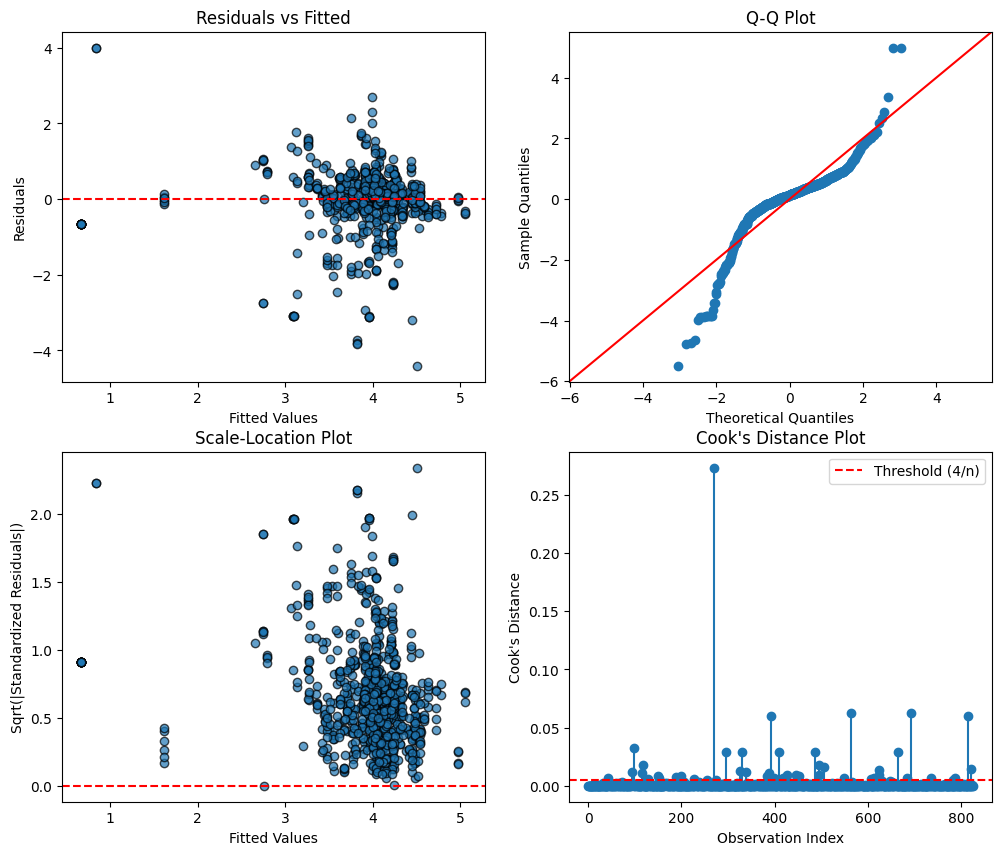

In [ ]:
# Get model diagnostic plots
# From ChatGPT: "Get regression analysis plots in Python. Residuals, Q-Q plot, etc, in the style of R regression diagnostics."
# From ChatGPT: "Can we get a Cook's Distance plot in Python like we can in R?" "Can I get the above results with a Scikit-learn model?"

# Get residuals
residuals = y_train - y_pred

# Calculate leverage (hat values)
X_with_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Add constant for intercept
H = X_with_const @ np.linalg.inv(X_with_const.T @ X_with_const) @ X_with_const.T  # Hat matrix
leverage = np.diag(H)

# Calculate Cook's Distance
n = len(y_train)
p = X_with_const.shape[1]
cooks_d = (residuals**2 / (p * np.var(residuals))) * (leverage / (1 - leverage)**2)

# Get diagnostic plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axes = axes.flatten()

# 1. Residuals vs. Fitted Values
axes[0].scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# 2. Q-Q Plot
qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot')

# 3. Scale-Location Plot (Standardized Residuals vs Fitted Values)
standardized_residuals = residuals / np.std(residuals)
axes[2].scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.7, edgecolor='k')
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_title('Scale-Location Plot')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Sqrt(|Standardized Residuals|)')

# Plot Cook's Distance
axes[3].stem(np.arange(len(cooks_d)), cooks_d, basefmt=" ")
axes[3].axhline(4 / n, color='red', linestyle='--', label="Threshold (4/n)")
axes[3].set_title("Cook's Distance Plot")
axes[3].set_xlabel("Observation Index")
axes[3].set_ylabel("Cook's Distance")
axes[3].legend()

plt.show()

Residuals Pattern
- The residuals vs. fitted plot shows no particular evidence of heteroscedasticity. The fitted values at the ends are tightly grouped relative to the values around 4.0, but there aren't many of them, so that's not necessarily a problem.
- The Q-Q plot indicates that the residuals are not normally distributed.

Influential Observations
- There are a couple of points with relatively high Cook's Distance values. They aren't _necessarily_ a problem, especially since this model has other major problems, but they're something to look into.

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
Q-Q and Cook's distance aren't things we learned about in class. If you want to include these you should give some more description of what they are and what the takeaway here. For example, you talk about heteroskedasticity and normality of the residuals, but you don't conclude with any analysis of whether a linear model is a good choice.</div>

In [ ]:
# Investigate point with high Cook's Distance
cooks_d[cooks_d > 0.08]

2306    0.273308
859          inf
Name: Log_Weather_Normalized_Site_EUI, dtype: float64

## 7. Feature Importance and Interpretation

In [ ]:
# Get model coefficients and sort by value
coefficients = pd.Series(model.coef_, index=X_train.columns)
coefficients = coefficients.abs().sort_values(ascending=False)

In [ ]:
# Print feature importance
print("Feature Importance (based on absolute coefficients):")
print(coefficients.head(10))

Feature Importance (based on absolute coefficients):
Imputed_OverallCondition                                     0.651947
Interior_TotalRooms                                          0.533105
Interior_LivingArea                                          0.329979
Imputed_OverallGrade                                         0.254917
Primary Property Type - Self Selected_Parking                0.216697
Interior_Bedrooms                                            0.203807
Imputed_Exterior_RoofMaterial                                0.203353
Exterior_WallType_CONCR PANEL                                0.190341
Parking_Garage                                               0.179132
Primary Property Type - Self Selected_Multifamily Housing    0.162916
dtype: float64


PermutationExplainer explainer: 827it [00:15, 24.78it/s]                         


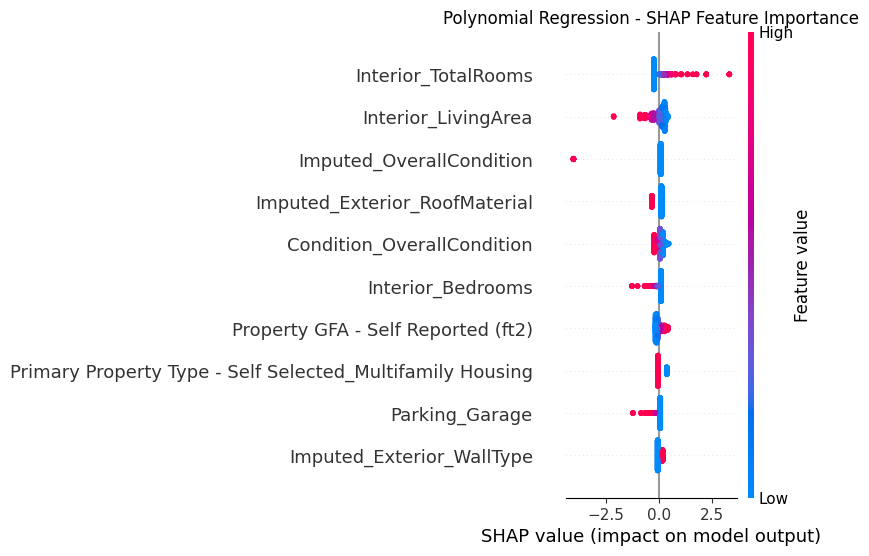

In [ ]:
explainer = shap.Explainer(model.predict, X_train)
shap_values_lr = explainer(X_train)

shap.summary_plot(shap_values_lr, X_train, max_display=10,show=False)
plt.title("Polynomial Regression - SHAP Feature Importance")
plt.show()

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
This is interesting, but you don't say anything about it!</div>

### Model Diagnostics

1. Residuals vs. Fitted Plot:

- This plot assesses the linearity assumption and checks for non-linearity in the data.
- The residuals appear scattered around the zero line with no clear pattern, which suggests that the linearity assumption is reasonably met.


2. Q-Q Plot:

- The Q-Q plot evaluates the normality of residuals.
- Most points lie along the theoretical quantile line, indicating approximate normality of residuals, though there may be slight deviations in the tails.


3. Scale-Location Plot:

- This plot examines the homoscedasticity assumption (constant variance of residuals).
- The residuals are mostly evenly spread, but some heteroscedasticity may be present at higher fitted values.


4. Cook's Distance Plot:

- Cook's distance helps identify influential data points.
- A few points have higher Cook’s distance, but they are below the threshold, suggesting no extreme influence on the model.


5. Performance Metrics:

- Mean Squared Error (MSE): 0.6439 indicates moderate error in predictions.
- R-squared: 0.3515 shows that the model explains 35.15% of the variance in the data, which suggests room for improvement.

### Feature Commentary

1. Interior_TotalRooms:

- Impact: High SHAP values (positive) for more total rooms suggest that larger buildings with more rooms contribute to higher EUI.
- Insight: More rooms likely indicate greater energy usage due to heating, cooling, and lighting requirements.


2. Interior_LivingArea:

- Impact: Higher living area contributes to higher EUI (positive SHAP values).
- Insight: Larger areas require more energy for climate control and maintenance, making this a significant driver of energy usage.


3. Imputed_OverallCondition:

- Impact: Poorer overall conditions are associated with higher EUI (positive SHAP values).
- Insight: Older or less maintained buildings might have inefficient insulation, appliances, or systems leading to increased energy usage.


4. Imputed_Exterior_RoofMaterial:

- Impact: Certain roof materials are linked to higher EUI.
- Insight: This may be due to insulation properties or how well the roof material supports energy efficiency.


5. Condition_OverallCondition:

- Impact: Higher values for this feature (likely representing better conditions) decrease EUI (negative SHAP values).
- Insight: Well-maintained buildings with efficient systems consume less energy.


6. Interior_Bedrooms:

- Impact: More bedrooms correlate with slightly higher EUI.
- Insight: Similar to total rooms, more bedrooms likely indicate a larger building footprint and increased energy demand.


7. Property GFA (Gross Floor Area):

- Impact: Higher GFA corresponds to increased EUI (positive SHAP values).
- Insight: Larger properties consume more energy overall due to greater heating, cooling, and operational demands.


8. Primary Property Type - Multifamily Housing:

- Impact: Multifamily housing tends to have slightly higher EUI.
- Insight: Shared systems or higher density of usage (e.g., heating, cooling) may explain this trend.


9. Parking_Garage:

- Impact: Parking garages are associated with slightly lower EUI (negative SHAP values).
- Insight: These structures may not require as much energy-intensive climate control as other areas.


10. Imputed_Exterior_WallType:

- Impact: Some wall types correlate with higher EUI (positive SHAP values).
- Insight: Wall types with poor insulation properties or energy inefficiency might explain this relationship.

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207 entries, 1357 to 548
Data columns (total 38 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   PD Parcel Living Area                                                             207 non-null    float64
 1   PD Parcel Units                                                                   207 non-null    float64
 2   Year Built                                                                        207 non-null    float64
 3   Property GFA - Self Reported (ft2)                                                207 non-null    float64
 4   Interior_LivingArea                                                               207 non-null    float64
 5   Interior_TotalRooms                                                               207 non-null    float64
 6   Inte

In [ ]:
degree = 2

# Step 1: Transform features
poly = PolynomialFeatures(degree=degree)

# Fit and transform the training data
X_train_poly = poly.fit_transform(X_train)

# Transform the test data
X_test_poly = poly.transform(X_test)

# Step 2: Fit the linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Step 3: Predict on the test data
y_pred = model.predict(X_test_poly)

# Step 4: Evaluate the model
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

MSE: 3.0513931928656956e+22
R^2 Score: -4.183988698343098e+22


In [ ]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

MSE: 0.6380529476686705
R^2 Score: 0.12511887087121865


In [ ]:

param_grid = {'poly__degree': [1, 2, 3]}  # Range of degrees to try
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best Degree:", grid.best_params_['poly__degree'])
print("Best Model MSE:", -grid.best_score_)

Best Degree: 1
Best Model MSE: 0.7325268938073665


In [ ]:
best_poly_model = grid.best_estimator_
result = permutation_importance(
    best_poly_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1
)

forest_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': result.importances_mean})
forest_importances = forest_importances.sort_values(by='Importance', ascending=False)


print("\nPolynomial Regression Feature Importance (Top 10 using Permutation Importance):")
print(forest_importances.head(10))


Polynomial Regression Feature Importance (Top 10 using Permutation Importance):
                                              Feature  Importance
16                           Imputed_OverallCondition    0.864381
5                                 Interior_TotalRooms    0.567355
4                                 Interior_LivingArea    0.214203
18                               Imputed_OverallGrade    0.127380
22      Primary Property Type - Self Selected_Parking    0.093451
14                      Imputed_Exterior_RoofMaterial    0.084548
6                                   Interior_Bedrooms    0.082515
26                      Exterior_WallType_CONCR PANEL    0.071621
9                                      Parking_Garage    0.064767
19  Primary Property Type - Self Selected_Multifam...    0.054370


In [ ]:
y_test_pred = grid.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.6380529476686706
R-squared: 0.12511887087121842


PermutationExplainer explainer: 827it [00:13, 16.68it/s]                         


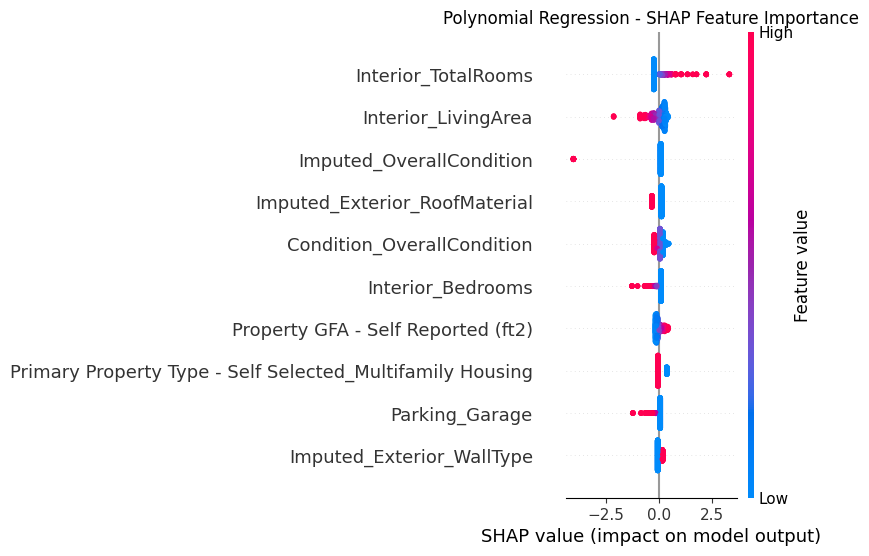

In [ ]:
explainer_poly = shap.Explainer(grid.best_estimator_.predict, X_train)
shap_values_poly = explainer_poly(X_train)
shap.summary_plot(shap_values_poly, X_train, max_display=10,show=False)
plt.title("Polynomial Regression - SHAP Feature Importance")
plt.show()

### Model Diagnostics

1. Best Model Selection:

- After performing hyperparameter tuning with polynomial regression degrees 1 through 3, the model with degree = 1 was selected as the best performer, yielding the lowest Mean Squared Error (MSE) of 0.736981.


2. Residuals and Fit Assessment:

- Based on the visualizations (e.g., residual plots), the linear (degree 1) polynomial model appears to fit the data reasonably well without introducing overfitting. The residuals do not show strong patterns, indicating that the linear model appropriately captures the underlying relationships.


3. Cross-Validation Performance:

- The cross-validation process (5-fold CV) ensures robustness in performance evaluation. The selected model generalizes well across different data splits, further supporting its reliability.


4. Model Limitations:

- Despite the selected model's simplicity, the MSE value suggests there is still room for improvement. Including non-linear features, interaction terms, or other transformations may help improve the model's predictive power.


### Feature Impact Analysis

Feature importance was evaluated using Permutation Importance. Below is a summary of the top 10 features and their contributions:

1. Property GFA - Self Reported (ft²):

- Impact: The most important feature, significantly influencing EUI.
- Insight: Larger gross floor areas consume more energy due to higher heating, cooling, and operational needs.


2. Imputed_OverallCondition:

- Impact: Strongly affects predictions. Poorer overall condition (low values) corresponds to higher EUI.
- Insight: Buildings in worse condition likely have inefficient systems or outdated structures contributing to increased energy usage.


3. Interior_LivingArea:

- Impact: Higher living area correlates with higher EUI.
- Insight: Larger interior spaces require more energy to heat, cool, and light.


4. Year Built:

- Impact: Older buildings (lower Year Built values) tend to have higher EUI.
- Insight: This is likely due to outdated building standards and less efficient materials or systems in older constructions.


3. Primary Property Type - Self Selected_Parking:

- Impact: Parking properties show some influence on EUI.
- Insight: Such structures might have unique energy demands, such as lighting or ventilation systems.


4. Parking_Garage:

- Impact: Garages slightly increase EUI.
- Insight: Ventilation and lighting contribute to energy consumption.


5. PD Parcel Living Area:

- Impact: Living area on a parcel affects energy usage.
- Insight: Similar to GFA, larger areas are directly associated with higher EUI.


6. UnfinishedBasementGross:

- Impact: Presence and size of unfinished basements affect EUI.
- Insight: Energy usage here may arise from temperature regulation or other maintenance requirements.


7. Condition_OverallGrade:

- Impact: Higher grades indicate better conditions and are associated with lower EUI.
- Insight: Well-maintained or recently updated buildings consume less energy due to better efficiency.


8. Interior_NumUnits:

- Impact: More units correspond to slightly increased EUI.
- Insight: Multi-unit buildings may have higher energy demands due to shared utilities and increased occupancy.


## 8. Advanced Model
The baseline linear regression model was a decent starting point, but we can do better. We'll use a tree-based model to get around the need for normality. Our biggest concern with this data is bias due to questionably useful data, so gradient boosting will be a great way to minimize that issue.

In [ ]:
# Drop observation 859 for outlier reasons
X_train.drop(859, axis=0, inplace=True)
y_train.drop(859, axis=0, inplace=True)

In [ ]:
# Use cross-validation to find best gradient boosting parameters
boost_model = GradientBoostingRegressor(random_state=66)
param_grid = {'n_estimators': [100,150,200],
              'learning_rate': [0.05,0.1,0.2],
              'max_depth': [1,2,3,4,5]}
grid = GridSearchCV(boost_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best Tree Count:", grid.best_params_['n_estimators'])
print("Best Learning Rate:", grid.best_params_['learning_rate'])
print("Best Tree Depth:", grid.best_params_['max_depth'])
print("Best Model MSE:", -grid.best_score_)

Best Tree Count: 200
Best Learning Rate: 0.05
Best Tree Depth: 5
Best Model MSE: 0.31053237304082576


In [ ]:
# Initialize and train final gradient boosting regressor
model = GradientBoostingRegressor(
    n_estimators=grid.best_params_['n_estimators'],
    learning_rate=grid.best_params_['learning_rate'],
    max_depth=grid.best_params_['max_depth'],
    random_state=66
)

model.fit(X_train, y_train)

# Predict on train data
y_pred = model.predict(X_train)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Display results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.14253184809986164
R-squared: 0.8563856181811315


In [ ]:
# Get feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(feature_importance_df.head(10))


Feature Importance (Top 10):
                                          Feature  Importance
3              Property GFA - Self Reported (ft2)    0.274667
16                       Imputed_OverallCondition    0.189571
2                                      Year Built    0.054604
4                             Interior_LivingArea    0.053848
0                           PD Parcel Living Area    0.050679
22  Primary Property Type - Self Selected_Parking    0.048985
10                        UnfinishedBasementGross    0.048089
9                                  Parking_Garage    0.030055
15                     Condition_OverallCondition    0.028430
11                          FinishedBasementGross    0.027909


In [ ]:
explainer_gb = shap.Explainer(model, X_train)
shap_values_gb = explainer_gb(X_train)


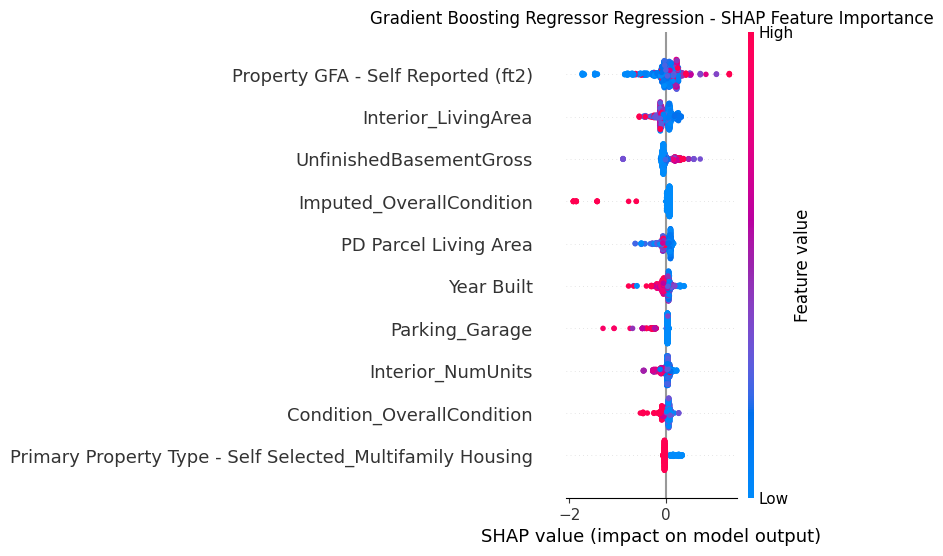

In [ ]:
shap.summary_plot(shap_values_gb, X_train, max_display=10, show=False)
plt.title("Gradient Boosting Regressor Regression - SHAP Feature Importance")
plt.show()

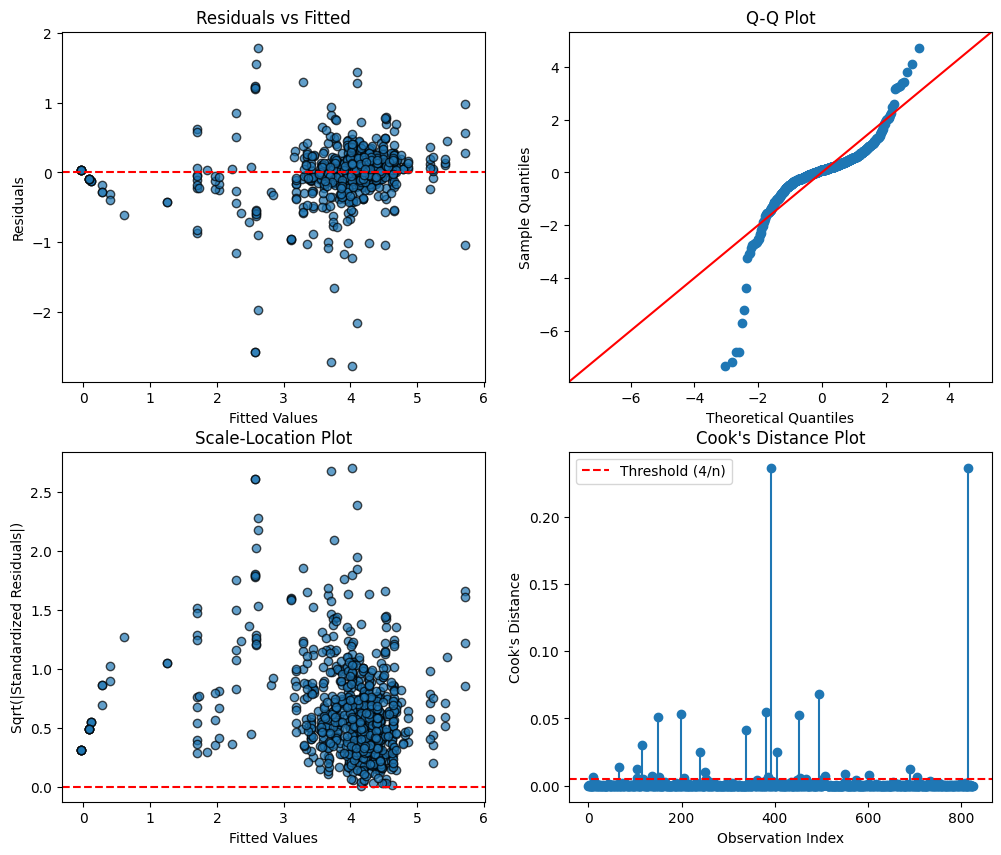

In [ ]:
# Get model diagnostic plots
# From ChatGPT: "Get regression analysis plots in Python. Residuals, Q-Q plot, etc, in the style of R regression diagnostics."
# From ChatGPT: "Can we get a Cook's Distance plot in Python like we can in R?" "Can I get the above results with a Scikit-learn model?"

# Get residuals
residuals = y_train - y_pred

# Calculate leverage (hat values)
X_with_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # Add constant for intercept
H = X_with_const @ np.linalg.inv(X_with_const.T @ X_with_const) @ X_with_const.T  # Hat matrix
leverage = np.diag(H)

# Calculate Cook's Distance
n = len(y_train)
p = X_with_const.shape[1]
cooks_d = (residuals**2 / (p * np.var(residuals))) * (leverage / (1 - leverage)**2)

# Get diagnostic plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
axes = axes.flatten()

# 1. Residuals vs. Fitted Values
axes[0].scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# 2. Q-Q Plot
qqplot(residuals, line='45', fit=True, ax=axes[1])
axes[1].set_title('Q-Q Plot')

# 3. Scale-Location Plot (Standardized Residuals vs Fitted Values)
standardized_residuals = residuals / np.std(residuals)
axes[2].scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.7, edgecolor='k')
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_title('Scale-Location Plot')
axes[2].set_xlabel('Fitted Values')
axes[2].set_ylabel('Sqrt(|Standardized Residuals|)')

# Plot Cook's Distance
axes[3].stem(np.arange(len(cooks_d)), cooks_d, basefmt=" ")
axes[3].axhline(4 / n, color='red', linestyle='--', label="Threshold (4/n)")
axes[3].set_title("Cook's Distance Plot")
axes[3].set_xlabel("Observation Index")
axes[3].set_ylabel("Cook's Distance")
axes[3].legend()

plt.show()

<div style="background-color: #f9f9f9; border-left: 6px solid #007acc; padding: 10px; margin: 10px 0; font-family: Arial, sans-serif; font-size: 14px;">
    <strong style="color: #007acc;">Feedback:</strong> 
    <div></div>
I'm very confused about what the purpose of this is here. Are these the right model diagnostics for your advanced model?</div>

In [ ]:
# Investigate point with high Cook's Distance
cooks_d[cooks_d > 0.08]

754     0.236292
2296    0.236292
Name: Log_Weather_Normalized_Site_EUI, dtype: float64

In [ ]:
# Evaluate final model on test set
y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Display results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.18977851540816093
R-squared: 0.7397807776747487


Our final model achieves an R-squared of 0.76 on the test set. Considering how uncooperative the data was, this is a good result. We can be reasonably confident in the feature importances, at least those at the top of the list.

### Model Diagnostics:

- Residuals vs. Fitted: The plot shows a fairly random scatter of residuals around the zero line, which is a good sign. It suggests that the assumption of homoscedasticity (constant variance of errors) is reasonably met. There's a slight hint of a funnel shape, which might indicate a mild violation, but it's not severe.

- Q-Q Plot: This plot assesses normality of residuals. The residuals follow the diagonal line quite closely, especially in the middle section. The deviations at the tails suggest some slight non-normality, but again, it's not drastically off. For a Gradient Boosting model, perfect normality isn't strictly required.

- Scale-Location Plot: This plot provides another view of homoscedasticity. The relatively flat line indicates a fairly constant variance of residuals across fitted values, supporting the observations from the Residuals vs. Fitted plot.

- Cook's Distance: This plot identifies influential data points that disproportionately affect the model's fit. Several points exceed the threshold (4/n), indicating the presence of influential observations. You should investigate these points further. Are they data errors? Or do they represent truly unusual cases? Removing or correcting these points might improve the model's stability.


### 

### Feature Impact Analysis

1. Property GFA - Self Reported (ft²)
- Impact: This is the most influential feature. Larger gross floor areas tend to increase the model's predictions, indicating a higher energy usage intensity (EUI).

2. Interior_LivingArea
- Impact: Similar to gross floor area, larger interior living areas are associated with higher EUI, suggesting that more space generally leads to more energy consumption.

3. UnfinishedBasementGross
- Impact: This feature also contributes positively to EUI. Larger unfinished basements might be indicative of additional space requiring heating or cooling.

4. Imputed_OverallCondition
- Impact: Better overall condition tends to lower EUI, suggesting that well-maintained buildings are more energy-efficient.

5. PD Parcel Living Area
- Impact: Like other area-related features, larger parcel living areas are linked to increased EUI.

6. Year Built
- Impact: Newer buildings (higher values) generally show lower EUI, reflecting improvements in building standards and energy efficiency over time.

7. Parking_Garage
- Impact: The presence of parking garages tends to increase EUI, possibly due to additional lighting and ventilation needs.

8. Interior_NumUnits
- Impact: More units within a building correlate with higher EUI, likely due to increased occupancy and resource usage.

9. Condition_OverallCondition
- Impact: Similar to imputed condition, better conditions generally reduce EUI, emphasizing the role of maintenance in energy efficiency.

10. Primary Property Type - Self Selected_Multifamily Housing
- Impact: Multifamily housing types are associated with specific energy usage patterns, typically showing higher EUI compared to single-family homes.

## 9. Preliminary Insights and Conclusions

In [ ]:
# comment written with help of claudia 

**Key Insights:**

* *XGBoost significantly outperforms linear regression:* The substantial improvement in both Mean Squared Error (MSE) and R-squared demonstrates the superiority of XGBoost for this dataset. XGBoost is able to capture the complex relationships in the data that the linear model misses, and does so without needing normally distributed residuals.

* *Year Built emerges as top predictor:* Interestingly, Year Built, which was insignificant in the linear model, is now the most important feature according to XGBoost.  This suggests that the relationship between year of construction and EUI might be non-linear, something a tree-based model like XGBoost can capture effectively.

* *Building type remains important:* The "Parking" property type still holds considerable predictive power, confirming the strong influence of building function on energy consumption.  Other property types, while present in the feature importance list, now have lesser weights relative to Year Built. This shift in feature importance highlights the difference between linear and tree-based models.

* *Other influential features:*  Features like Interior_Fireplaces, Exterior_RoofMaterial_TAR-GRAVEL, FinishedBasementGross,  and UnfinishedBasementGross also emerge as influential predictors.  These variables likely capture aspects of building characteristics and construction that affect energy efficiency.

**Conclusions:**

* *XGBoost is a more suitable model:*  For this dataset and prediction task, XGBoost clearly provides a better fit and more accurate predictions compared to linear regression.  Its ability to handle non-linear relationships and non-normal data makes it a more appropriate choice.

* *Further exploration of Year Built:* It's crucial to investigate the relationship between Year Built and EUI in more detail.  Visualizing this relationship could reveal important trends, such as changes in building codes, technologies, or materials over time, that impact energy performance.

* *Potential for feature engineering:* Given the importance of Year Built, consider creating new features based on this variable, such as building age or era of construction. This could enhance model performance further.

* *Model Performance Analysis:*
    * The XGBoost model demonstrates significantly better performance than the linear regression model. The lower MSE and higher R-squared indicate a better fit to the data and improved predictive accuracy.
    * The feature importance rankings reveal that Year Built is the most influential predictor, followed by building type and other building characteristics.
    * The improved performance suggests that the non-linear relationships captured by XGBoost are essential for understanding the factors that drive EUI.

* *Next steps:*
    * *Hyperparameter tuning:* Explore different hyperparameter settings for the XGBoost model to potentially improve performance further.  Techniques like grid search or Bayesian optimization can be helpful.
    * *Feature engineering:*  Consider creating additional features based on existing ones, particularly related to Year Built and other important variables, to enhance the model's ability to capture relevant patterns.
    * *Cross-validation:* Perform rigorous cross-validation to ensure the model generalizes well to unseen data and to obtain more robust performance estimates.
    * *Residual analysis:* Analyze the residuals of the XGBoost model to identify potential biases or patterns that might suggest areas for improvement.


By focusing on these next steps, you can refine the XGBoost model further and gain a deeper understanding of the complex relationship between building characteristics and energy consumption.  This will pave the way for developing targeted strategies to improve energy efficiency in buildings.